In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io as skio
import torch.optim as optim
import skimage as sk
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
from torch.optim.lr_scheduler import StepLR

In [6]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
data = np.load(f"lego_200x200.npz")
images_train = data["images_train"] / 255.0
c2ws_train = data["c2ws_train"]
images_val = data["images_val"] / 255.0
c2ws_val = data["c2ws_val"]
c2ws_test = data["c2ws_test"]
focal = data["focal"]

In [8]:
height = 200
width = 200
n_samples = 32

In [9]:
K = np.array([[focal,0,width/2],[0,focal,height/2],[0,0,1]])

In [10]:
def transform(c2w, x_c):
    #camera to world
    num_rows = len(x_c)
    ones_column = np.ones((num_rows, 1))
    x_c_with_one = np.concatenate((x_c, ones_column), axis=1)
    x = (c2w @ x_c_with_one.T).T
    return x[:,:-1]

In [11]:
def pixel_to_camera(K, uv,s):
    num_rows = len(uv)
    ones_column = np.ones((num_rows, 1))
    uv_with_one = np.concatenate((uv, ones_column), axis=1)
    result = (np.linalg.inv(K) @ uv_with_one.T).T
    return result

In [12]:
def pixel_to_ray(K, c2w, uv):
    zeros = np.array([[0,0,0]])
    origin = transform(c2w, zeros)
    depth_1_points = pixel_to_camera(K, uv, 1)
    world_depth_1_points = transform(c2w, depth_1_points)
    world_depth_1_points_direction = world_depth_1_points - origin
    norms = np.linalg.norm(world_depth_1_points_direction, axis=1, keepdims=True)
    directions = world_depth_1_points_direction/ norms

    return origin, directions

In [13]:
class RaysData(Dataset):
    def __init__(self, img_train, K, c2ws_train):
        self.img = img_train
        self.c2ws = c2ws_train
        self.K = K
        self.height = 200
        self.width = 200
        self.length = len(self.img) * self.height * self.width

    def __len__(self):
        return len(self.img) * self.height * self.width
    
    def __getitem__(self, idx):
        img_index = idx // (self.width*self.height)
        residual = idx % (self.width*self.height)
        temp_height = residual // self.height 
        temp_width = residual % self.width 
        c2w = self.c2ws[img_index]
        uv = np.array([[temp_height+0.5, temp_width+0.5]])
        ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
        pixel = self.img[img_index,temp_height,temp_width,:]
        sample = {'rays_o':ray_o[0],
                  "rays_d":ray_d[0],
                 "pixels":pixel}
        return sample

    def sample_rays(self, num_samples):
        rays_o = []
        rays_d = []
        pixels = []
        # random_numbers = [random.randint(0,self.length -1) for _ in range(num_samples)]
        random_numbers = np.random.randint(0, self.length - 1, size=num_samples) 
        for random_number in random_numbers:
            img_index = random_number // (self.width*self.height)
            residual = random_number % (self.width*self.height)
            temp_height = residual // self.height 
            temp_width = residual % self.width 
            c2w = self.c2ws[img_index]
            uv = np.array([[temp_height+0.5, temp_width+0.5]])
            ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
            rays_o.append(ray_o[0])
            rays_d.append(ray_d[0])
            pixels.append(self.img[img_index,temp_height,temp_width,:])
        return rays_o, rays_d,pixels

In [11]:
# aaa =   torch.ones(100, 32) * torch.rand(1)*(6 - 2 )/ n_samples 

In [12]:
# aaa

In [14]:
def sample_along_rays(rays_o, rays_d, n_samples=32, perturb=True):
    far = 6 
    near = 2
    
    t_values = torch.linspace(near, far, n_samples).to(device)
    # ran_values = (torch.rand((len(rays_o), n_samples)) * (far - near) / n_samples).to(device)
    ran_values = torch.ones(len(rays_o), n_samples) * torch.rand(1)*(far - near) / n_samples 
    ran_values = ran_values.to(device)
    # Create 3D grid for rays_o and rays_d
    ray_o_grid = rays_o[:, None, :].repeat(1, n_samples, 1)
    ray_d_grid = rays_d[:, None, :].repeat(1, n_samples, 1)

    # Compute points without explicit loops
    if perturb:
        p_t = t_values + ran_values
    else:
        p_t = t_values + ran_values*0
    p_t = p_t.to(device)
    points = ray_o_grid + ray_d_grid * p_t.unsqueeze(2)

    return points.view(-1, 3)

In [33]:
# dataset = RaysData(images_train, K, c2ws_train)
# dataloader = DataLoader(dataset, batch_size=100,
#                         shuffle=True)

In [34]:
# data_iterator = iter(dataloader)
# one_batch = next(data_iterator)
# rays_o, rays_d, pixels = one_batch

# rays_o = one_batch['rays_o'].squeeze()
# rays_d = one_batch['rays_d'].squeeze()
# rays_o = rays_o.float()
# rays_d = rays_d.float()

In [35]:
# import viser, time  # pip install viser
# import numpy as np

# # --- You Need to Implement These ------
# dataset = RaysData(images_train, K, c2ws_train)
# dataloader = DataLoader(dataset, batch_size=100,
#                         shuffle=True)
# data_iterator = iter(dataloader)
# one_batch = next(data_iterator)
# rays_o, rays_d, pixels = one_batch

# rays_o = one_batch['rays_o'].squeeze()
# rays_d = one_batch['rays_d'].squeeze()
# rays_o = rays_o.float().to(device)
# rays_d = rays_d.float().to(device)
# points = sample_along_rays(rays_o, rays_d, perturb=True)
# H, W = images_train.shape[1:3]

In [36]:
# points = points.detach().cpu().numpy()
# rays_o = rays_o.detach().cpu().numpy()
# rays_d = rays_d.detach().cpu().numpy()

In [37]:
# server = viser.ViserServer(share=True)
# for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
#     server.add_camera_frustum(
#         f"/cameras/{i}",
#         fov=2 * np.arctan2(H / 2, K[0, 0]),
#         aspect=W / H,
#         scale=0.15,
#         wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
#         position=c2w[:3, 3],
#         image=image
#     )
# for i, (o, d) in enumerate(zip(rays_o, rays_d)):
#     server.add_spline_catmull_rom(
#         f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
#     )
# server.add_point_cloud(
#     f"/samples",
#     colors=np.zeros_like(points).reshape(-1, 3),
#     points=points.reshape(-1, 3),
#     point_size=0.02,
# )
# time.sleep(1000)

(viser) Share URL requested! (expires in 24 hours)

╭───────────────────────── viser ─────────────────────────╮
│             ╷                                           │
│   HTTP      │ http://0.0.0.0:8082                       │
│   Websocket │ ws://0.0.0.0:8082                         │
│   Share URL │ https://shadow-cheap.share.viser.studio   │
│             ╵                                           │
╰─────────────────────────────────────────────────────────╯

(viser) Connection closed (0, 0 total)

(viser) Connection opened (0, 1 total), 506 persistent messages

(viser) Connection closed (0, 0 total)

KeyboardInterrupt: 

In [15]:
def volrend(sigmas, rgbs, step_size):
    sigmas = sigmas.to(device)
    rgbs = rgbs.to(device)
    size_to_prepend = (sigmas.size(0), 1, 1)

    zeros_to_prepend = torch.zeros(size_to_prepend, dtype=sigmas.dtype).to(device)
    
    tensor_with_zeros = torch.cat((zeros_to_prepend, sigmas), dim=1).to(device)

    
    
    cum_sigmas = torch.cumsum(tensor_with_zeros,dim=1)[:,:-1].to(device)
    T = torch.exp(-cum_sigmas*step_size).to(device)
    interval_sigmas = 1 - torch.exp(-sigmas*step_size).to(device)
    weights = T * interval_sigmas
    colors = rgbs * weights
    cum_colors = torch.sum(colors, dim=1).to(device)

    return cum_colors

In [16]:
class Residual_block(nn.Module):
    def __init__(self, dim):
        super(Residual_block, self).__init__()
        self.dim = dim
        self.linear_1 = nn.Linear(dim, dim)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=dim)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(dim, dim)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=dim)
        nn.init.kaiming_normal_(self.linear_1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.linear_2.weight, mode='fan_in', nonlinearity='relu')

    def forward(self,x):
        origin_x = x
        x = self.linear_1(x)
        x = self.layer_norm_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.layer_norm_2(x)
        x = self.relu(x + origin_x)
        return x

In [17]:
class Nerf_model(nn.Module):
    def __init__(self,high_fre_level, high_fre_level_angle, hidden_dim):
        super(Nerf_model, self).__init__()
        self.high_fre_level = high_fre_level
        self.high_fre_level_angle = high_fre_level_angle
        self.pe_dim = 3+high_fre_level*6
        self.pe_dim_angle = 3 + 6 * high_fre_level_angle
        self.input_layer = nn.Linear(3+high_fre_level*6, hidden_dim)
        self.residual_block_1 = Residual_block(hidden_dim)
        self.residual_block_2 = Residual_block(hidden_dim)
        self.residual_block_3 = Residual_block(hidden_dim)
        
        self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.hidden_layer_concat_angle = nn.Linear(hidden_dim + self.pe_dim_angle, hidden_dim//2)

        nn.init.kaiming_normal_(self.hidden_layer_concat_angle.weight, mode='fan_in', nonlinearity='relu')
        
        self.out = nn.Linear(hidden_dim//2, 3)
        nn.init.kaiming_normal_(self.out.weight, mode='fan_in', nonlinearity='relu')
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.density_layer = nn.Linear(hidden_dim, 1)

        power_terms_pos = (torch.exp2(torch.arange(0, high_fre_level))*3.14159).to(device)
        
        power_terms_angle = (torch.exp2(torch.arange(0, high_fre_level_angle))*3.14159).to(device)
        
        self.power_matrix_pos= torch.zeros(3, self.high_fre_level *3).to(device)
        for i in range(3):
            self.power_matrix_pos[i,i*high_fre_level:(i+1)*high_fre_level] = power_terms_pos

        self.power_matrix_angle = torch.zeros(3, self.high_fre_level_angle  *3).to(device)
        for i in range(3):
            self.power_matrix_angle[i,i*high_fre_level_angle :(i+1)*high_fre_level_angle ] = power_terms_angle


        self.middle_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim) 
        
        self.last_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim//2) 

    def positional_encoding(self, data, high_fre_level, power_matrix):

        powered_data = data @ power_matrix
        sin_matrix = torch.sin(powered_data).to(device)
        cos_matrix = torch.cos(powered_data).to(device)

        pe = torch.cat((data, sin_matrix, cos_matrix),1).to(device)

        return pe

    def forward(self,pos, angle):
                
        pos_pe = self.positional_encoding(pos, self.high_fre_level, self.power_matrix_pos)
        
        origin_x = pos_pe
        x = self.input_layer(origin_x)
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        x = self.residual_block_3(x)
        x = self.hidden_layer_1(x)
        sigmas = self.density_layer(x)
        sigmas = self.relu(sigmas)

        # x = self.middle_layer_norm(x)
        x = self.hidden_layer_2(x)

        angle_pe = self.positional_encoding(angle, self.high_fre_level_angle, self.power_matrix_angle)
        # angle_input = torch.cat((angle,angle_pe),dim=1)
        concated_x = torch.cat((x,angle_pe), dim = 1).float()
        x = self.hidden_layer_concat_angle(concated_x)
        x = self.last_layer_norm(x)
        x = self.relu(x)
        x = self.out(x)
        x = self.sigmoid(x)
        return x, sigmas

In [14]:
# class Nerf_model(nn.Module):
#     def __init__(self,high_fre_level, high_fre_level_angle, hidden_dim):
#         super(Nerf_model, self).__init__()
#         self.high_fre_level = high_fre_level
#         self.high_fre_level_angle = high_fre_level_angle
#         self.pe_dim = 3+high_fre_level*6
#         self.pe_dim_angle = 3 + 6 * high_fre_level_angle
#         self.input_layer = nn.Linear(3+high_fre_level*6, hidden_dim)
#         # self.input_layer = nn.Linear(2, hidden_dim)
#         hidden_layer_list = []


        
#         for i in range(3):
#             hidden_layer_list.append(nn.Linear(hidden_dim, hidden_dim))
#             hidden_layer_list.append(nn.ReLU())
#         self.hidden_layer_1 = nn.Sequential(*hidden_layer_list)

#         self.concat_hidden_layer = nn.Linear(hidden_dim + self.pe_dim,hidden_dim)
        
#         hidden_layer_list = []
#         for i in range(2):
#             hidden_layer_list.append(nn.Linear(hidden_dim, hidden_dim))
#             hidden_layer_list.append(nn.ReLU())
#         self.hidden_layer_2 = nn.Sequential(*hidden_layer_list)

#         self.hidden_layer_3 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_4 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_5 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_concat_angle = nn.Linear(hidden_dim + self.pe_dim_angle, hidden_dim//2)

#         self.out = nn.Linear(hidden_dim//2, 3)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
#         self.density_layer = nn.Linear(hidden_dim, 1)
        
#         power_terms_pos = (torch.exp2(torch.arange(0, high_fre_level))*3.14159).to(device)
        
#         power_terms_angle = (torch.exp2(torch.arange(0, high_fre_level_angle))*3.14159).to(device)
        
#         self.power_matrix_pos= torch.zeros(3, self.high_fre_level *3).to(device)
#         for i in range(3):
#             self.power_matrix_pos[i,i*high_fre_level:(i+1)*high_fre_level] = power_terms_pos

#         self.power_matrix_angle = torch.zeros(3, self.high_fre_level_angle  *3).to(device)
#         for i in range(3):
#             self.power_matrix_angle[i,i*high_fre_level_angle :(i+1)*high_fre_level_angle ] = power_terms_angle

#         # self.layer_norm1 = nn.LayerNorm(normalized_shape=HIDDEN_UNITS)  
#         # self._initialize_weights()
#         self.last_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim//2) 
        

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)


    


#     def positional_encoding(self, data, high_fre_level, power_matrix):

#         powered_data = data @ power_matrix
#         sin_matrix = torch.sin(powered_data).to(device)
#         cos_matrix = torch.cos(powered_data).to(device)

#         pe = torch.cat((data, sin_matrix, cos_matrix),1).to(device)

#         return pe




    
#     def forward_phase_1(self, origin_x):

#         x = self.input_layer(origin_x)
#         x = self.relu(x)
#         x = self.hidden_layer_1(x)
#         x = torch.cat((x,origin_x), dim = 1)
#         x = self.concat_hidden_layer(x)
#         x = self.relu(x)
#         x = self.hidden_layer_2(x)
#         x = self.hidden_layer_3(x)
#         return x


        
#     def forward(self, pos, angle):
        
#         pos_pe = self.positional_encoding(pos, self.high_fre_level, self.power_matrix_pos)
        
#         origin_x = pos_pe
#         x = self.forward_phase_1(origin_x)




        
#         sigmas = self.density_layer(x)
#         sigmas = self.relu(sigmas)
        
#         x = self.hidden_layer_4(x)
#         angle_pe = self.positional_encoding(angle, self.high_fre_level_angle, self.power_matrix_angle)
#         # angle_input = torch.cat((angle,angle_pe),dim=1)
#         concated_x = torch.cat((x,angle_pe), dim = 1).float()
#         x = self.hidden_layer_concat_angle(concated_x)
#         x = self.last_layer_norm(x)
#         x = self.relu(x)
#         x = self.out(x)
#         x = self.sigmoid(x)
#         return x, sigmas
        

In [17]:
def calcualte_PSNR():
    model.eval()
    loss_fn = nn.SmoothL1Loss(reduction='sum')
    dataset = RaysData(images_val, K, c2ws_val)
    dataloader = DataLoader(dataset, batch_size=10000,
                        shuffle=True)
    loss = 0
    for i_batch, sample_batched in enumerate(tqdm(dataloader)):
        # print(len(sample_batched['pixels']))
        # rays_o, rays_d, pixels = dataset.sample_rays(10000)
        # rays_o, rays_d, pixels = dataset.sample_rays_one(1000)
        # t1 = time.time()
        rays_o = sample_batched['rays_o'].squeeze()
        rays_d = sample_batched['rays_d'].squeeze()
        pixels = sample_batched['pixels']
        rays_o = rays_o.float().to(device)
        rays_d = rays_d.float().to(device)
        # rays_d = np.array(rays_d)
        # rays_o = np.array(rays_o)
        # rays_d = torch.tensor(rays_d).to(device)
        # rays_o = torch.tensor(rays_o).to(device)
        points = sample_along_rays(rays_o, rays_d)
        
    
        points = points.float().to(device)
        # points = np.array(points)
        # rays_d = np.array(rays_d)
        # points = torch.tensor(points).to(device)
        # rays_d = torch.tensor(rays_d).to(device)
    
        rays_d = torch.unsqueeze(rays_d,1)
        rays_d = rays_d.repeat(1,n_samples,1)
        rays_d = rays_d.view(-1,3)
        
        # t2 = time.time()
        # print('p',t2-t1)
        # t1 = t2
        
        rgbs, sigmas = model(points, rays_d)
        
        # t2 = time.time()
        # print('forward',t2-t1)
        # t1 = t2
        
        rgbs = rgbs.to(device)
        sigmas = sigmas.to(device)
        # sigams = model.foward_dentisy()
        sigmas = sigmas.view(-1, n_samples, 1)
        rgbs = rgbs.view(-1, n_samples, 3)
        
    
    
        rendered_colors = volrend(sigmas, rgbs, step_size)

                
        # t2 = time.time()
        # print('render',t2-t1)
        # t1 = t2
        # print("render",rendered_colors[0])
        # print("pixels",pixels[0])
    
        pixels = pixels.float().to(device)

        with torch.no_grad():
            loss += loss_fn(rendered_colors, pixels)
    return loss.item()/len(dataset)

In [18]:
model = Nerf_model(30,10,256).to(device)
step_size = (6-2)/n_samples

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

2023-11-06 22:37:08.493766: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 22:37:09.006245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
PSNR_loss_list = []

global_iter = 0

In [22]:
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# criterion = PSNRWithMSELoss()
criterion = torch.nn.MSELoss()
number_epoch  = 130
model.train()
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
# for i in range(number_iteration):

dataset = RaysData(images_train, K, c2ws_train)
dataloader = DataLoader(dataset, batch_size=10000,
                        shuffle=True)

for e in range(number_epoch):
    for i_batch, sample_batched in enumerate(tqdm(dataloader)):
        # print(len(sample_batched['pixels']))
        # rays_o, rays_d, pixels = dataset.sample_rays(10000)
        # rays_o, rays_d, pixels = dataset.sample_rays_one(1000)
        # t1 = time.time()
        rays_o = sample_batched['rays_o'].squeeze()
        rays_d = sample_batched['rays_d'].squeeze()
        pixels = sample_batched['pixels']
        rays_o = rays_o.float().to(device)
        rays_d = rays_d.float().to(device)
        # rays_d = np.array(rays_d)
        # rays_o = np.array(rays_o)
        # rays_d = torch.tensor(rays_d).to(device)
        # rays_o = torch.tensor(rays_o).to(device)
        points = sample_along_rays(rays_o, rays_d)
        
    
        points = points.float().to(device)
        # points = np.array(points)
        # rays_d = np.array(rays_d)
        # points = torch.tensor(points).to(device)
        # rays_d = torch.tensor(rays_d).to(device)
    
        rays_d = torch.unsqueeze(rays_d,1)
        rays_d = rays_d.repeat(1,n_samples,1)
        rays_d = rays_d.view(-1,3)
        
        # t2 = time.time()
        # print('p',t2-t1)
        # t1 = t2
        
        rgbs, sigmas = model(points, rays_d)
        
        # t2 = time.time()
        # print('forward',t2-t1)
        # t1 = t2
        
        rgbs = rgbs.to(device)
        sigmas = sigmas.to(device)
        # sigams = model.foward_dentisy()
        sigmas = sigmas.view(-1, n_samples, 1)
        rgbs = rgbs.view(-1, n_samples, 3)
        
    
    
        rendered_colors = volrend(sigmas, rgbs, step_size)

                
        # t2 = time.time()
        # print('render',t2-t1)
        # t1 = t2
        # print("render",rendered_colors[0])
        # print("pixels",pixels[0])
    
        pixels = pixels.float().to(device)
        # pixels = np.array(pixels)
        # pixels = torch.tensor(pixels).float().to(device)
    
        # print(rendered_colors)
        loss = criterion(rendered_colors, pixels)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

                        
        # t2 = time.time()
        # print('backward',t2-t1)
        # t1 = t2
        # scheduler.step()
        # if global_iter % 100 ==0:
        #     PSNR_loss_list.append(calcualte_PSNR())
        #     print(PSNR_loss_list[-1])
        global_iter += 1
        if i_batch % 49 == 0:
            print(f'iteration [{i_batch}], Loss: {loss.item()}')
    scheduler.step()
    torch.save(model.state_dict(), 'weights_%s.pth'%e)

  0%|                                           | 1/400 [00:00<06:02,  1.10it/s]

iteration [0], Loss: 0.005415339022874832


 12%|█████▎                                    | 50/400 [00:23<03:12,  1.82it/s]

iteration [49], Loss: 0.005417889449745417


 25%|██████████▍                               | 99/400 [00:48<02:39,  1.89it/s]

iteration [98], Loss: 0.005776182282716036


 37%|███████████████▏                         | 148/400 [01:12<02:29,  1.68it/s]

iteration [147], Loss: 0.005436665844172239


 49%|████████████████████▏                    | 197/400 [01:37<01:51,  1.82it/s]

iteration [196], Loss: 0.005511349532753229


 62%|█████████████████████████▏               | 246/400 [02:01<01:23,  1.86it/s]

iteration [245], Loss: 0.005347293335944414


 74%|██████████████████████████████▏          | 295/400 [02:26<01:00,  1.74it/s]

iteration [294], Loss: 0.00541437603533268


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:31,  1.76it/s]

iteration [343], Loss: 0.005675845313817263


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.85it/s]

iteration [392], Loss: 0.005615824367851019


  0%|                                           | 1/400 [00:00<04:47,  1.39it/s]

iteration [0], Loss: 0.005432127974927425


 12%|█████▎                                    | 50/400 [00:25<03:26,  1.69it/s]

iteration [49], Loss: 0.005603647790849209


 25%|██████████▍                               | 99/400 [00:48<02:38,  1.90it/s]

iteration [98], Loss: 0.00544233713299036


 37%|███████████████▏                         | 148/400 [01:12<02:10,  1.94it/s]

iteration [147], Loss: 0.005763622000813484


 49%|████████████████████▏                    | 197/400 [01:35<01:52,  1.80it/s]

iteration [196], Loss: 0.005494855809956789


 62%|█████████████████████████▏               | 246/400 [01:59<01:24,  1.82it/s]

iteration [245], Loss: 0.0055470713414251804


 74%|██████████████████████████████▏          | 295/400 [02:22<00:54,  1.94it/s]

iteration [294], Loss: 0.005792029667645693


 86%|███████████████████████████████████▎     | 344/400 [02:46<00:31,  1.79it/s]

iteration [343], Loss: 0.00579171534627676


 98%|████████████████████████████████████████▎| 393/400 [03:09<00:03,  1.82it/s]

iteration [392], Loss: 0.005795890465378761


  0%|                                           | 1/400 [00:00<04:57,  1.34it/s]

iteration [0], Loss: 0.0055628144182264805


 12%|█████▎                                    | 50/400 [00:26<03:15,  1.79it/s]

iteration [49], Loss: 0.005847145803272724


 25%|██████████▍                               | 99/400 [00:51<02:58,  1.69it/s]

iteration [98], Loss: 0.005765997339040041


 37%|███████████████▏                         | 148/400 [01:15<02:20,  1.80it/s]

iteration [147], Loss: 0.005994993261992931


 49%|████████████████████▏                    | 197/400 [01:40<01:51,  1.82it/s]

iteration [196], Loss: 0.005717415828257799


 62%|█████████████████████████▏               | 246/400 [02:05<01:25,  1.80it/s]

iteration [245], Loss: 0.005788602866232395


 74%|██████████████████████████████▏          | 295/400 [02:30<01:01,  1.72it/s]

iteration [294], Loss: 0.005381312221288681


 86%|███████████████████████████████████▎     | 344/400 [02:55<00:30,  1.84it/s]

iteration [343], Loss: 0.005437276791781187


 98%|████████████████████████████████████████▎| 393/400 [03:20<00:03,  1.91it/s]

iteration [392], Loss: 0.005652842111885548


  0%|                                           | 1/400 [00:00<04:43,  1.41it/s]

iteration [0], Loss: 0.005363875534385443


 12%|█████▎                                    | 50/400 [00:24<03:06,  1.87it/s]

iteration [49], Loss: 0.005868273321539164


 25%|██████████▍                               | 99/400 [00:47<02:36,  1.92it/s]

iteration [98], Loss: 0.005824994761496782


 37%|███████████████▏                         | 148/400 [01:12<02:15,  1.86it/s]

iteration [147], Loss: 0.005480910651385784


 49%|████████████████████▏                    | 197/400 [01:37<01:55,  1.76it/s]

iteration [196], Loss: 0.005526679567992687


 62%|█████████████████████████▏               | 246/400 [02:00<01:24,  1.83it/s]

iteration [245], Loss: 0.005358614027500153


 74%|██████████████████████████████▏          | 295/400 [02:25<00:56,  1.85it/s]

iteration [294], Loss: 0.00540671544149518


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:32,  1.73it/s]

iteration [343], Loss: 0.005669889971613884


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.82it/s]

iteration [392], Loss: 0.005520786624401808


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.005396142136305571


 12%|█████▎                                    | 50/400 [00:26<03:14,  1.80it/s]

iteration [49], Loss: 0.005471903830766678


 25%|██████████▍                               | 99/400 [00:51<02:54,  1.72it/s]

iteration [98], Loss: 0.0056098573841154575


 37%|███████████████▏                         | 148/400 [01:17<02:20,  1.79it/s]

iteration [147], Loss: 0.005396523047238588


 49%|████████████████████▏                    | 197/400 [01:42<01:52,  1.81it/s]

iteration [196], Loss: 0.00526766013354063


 62%|█████████████████████████▏               | 246/400 [02:06<01:27,  1.77it/s]

iteration [245], Loss: 0.005567070562392473


 74%|██████████████████████████████▏          | 295/400 [02:31<00:57,  1.82it/s]

iteration [294], Loss: 0.005743250250816345


 86%|███████████████████████████████████▎     | 344/400 [02:56<00:30,  1.83it/s]

iteration [343], Loss: 0.005639570765197277


 98%|████████████████████████████████████████▎| 393/400 [03:21<00:04,  1.73it/s]

iteration [392], Loss: 0.005404352676123381


  0%|                                           | 1/400 [00:00<04:48,  1.38it/s]

iteration [0], Loss: 0.0052781556732952595


 12%|█████▎                                    | 50/400 [00:25<03:10,  1.83it/s]

iteration [49], Loss: 0.005518114194273949


 25%|██████████▍                               | 99/400 [00:49<02:43,  1.84it/s]

iteration [98], Loss: 0.005268089007586241


 37%|███████████████▏                         | 148/400 [01:14<02:24,  1.75it/s]

iteration [147], Loss: 0.005413704551756382


 49%|████████████████████▏                    | 197/400 [01:38<01:56,  1.74it/s]

iteration [196], Loss: 0.005429593846201897


 62%|█████████████████████████▏               | 246/400 [02:03<01:22,  1.86it/s]

iteration [245], Loss: 0.005822864826768637


 74%|██████████████████████████████▏          | 295/400 [02:28<00:59,  1.77it/s]

iteration [294], Loss: 0.005867542698979378


 86%|███████████████████████████████████▎     | 344/400 [02:53<00:30,  1.84it/s]

iteration [343], Loss: 0.006003638729453087


 98%|████████████████████████████████████████▎| 393/400 [03:17<00:03,  1.88it/s]

iteration [392], Loss: 0.005707663483917713


  0%|                                           | 1/400 [00:00<04:41,  1.41it/s]

iteration [0], Loss: 0.0059366109780967236


 12%|█████▎                                    | 50/400 [00:25<03:20,  1.75it/s]

iteration [49], Loss: 0.005163445137441158


 25%|██████████▍                               | 99/400 [00:50<02:49,  1.78it/s]

iteration [98], Loss: 0.005089424550533295


 37%|███████████████▏                         | 148/400 [01:14<02:11,  1.91it/s]

iteration [147], Loss: 0.0057645803317427635


 49%|████████████████████▏                    | 197/400 [01:38<01:51,  1.81it/s]

iteration [196], Loss: 0.005545781459659338


 62%|█████████████████████████▏               | 246/400 [02:02<01:21,  1.89it/s]

iteration [245], Loss: 0.005511149298399687


 74%|██████████████████████████████▏          | 295/400 [02:25<00:54,  1.92it/s]

iteration [294], Loss: 0.005231265444308519


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:32,  1.75it/s]

iteration [343], Loss: 0.005376513581722975


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.86it/s]

iteration [392], Loss: 0.005642335396260023


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.005335068795830011


 12%|█████▎                                    | 50/400 [00:24<03:02,  1.91it/s]

iteration [49], Loss: 0.005692352540791035


 25%|██████████▍                               | 99/400 [00:49<02:56,  1.71it/s]

iteration [98], Loss: 0.005399077199399471


 37%|███████████████▏                         | 148/400 [01:14<02:16,  1.84it/s]

iteration [147], Loss: 0.005664604716002941


 49%|████████████████████▏                    | 197/400 [01:38<02:02,  1.65it/s]

iteration [196], Loss: 0.005722287110984325


 62%|█████████████████████████▏               | 246/400 [02:03<01:20,  1.91it/s]

iteration [245], Loss: 0.005650458857417107


 74%|██████████████████████████████▏          | 295/400 [02:26<00:57,  1.82it/s]

iteration [294], Loss: 0.005361496936529875


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:28,  1.95it/s]

iteration [343], Loss: 0.005559826735407114


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.78it/s]

iteration [392], Loss: 0.005516400560736656


  0%|                                           | 1/400 [00:00<05:33,  1.20it/s]

iteration [0], Loss: 0.005889455322176218


 12%|█████▎                                    | 50/400 [00:24<03:09,  1.85it/s]

iteration [49], Loss: 0.005252685397863388


 25%|██████████▍                               | 99/400 [00:47<02:43,  1.85it/s]

iteration [98], Loss: 0.005410997662693262


 37%|███████████████▏                         | 148/400 [01:11<02:23,  1.76it/s]

iteration [147], Loss: 0.005370765458792448


 49%|████████████████████▏                    | 197/400 [01:35<01:48,  1.86it/s]

iteration [196], Loss: 0.005505274515599012


 62%|█████████████████████████▏               | 246/400 [01:58<01:22,  1.88it/s]

iteration [245], Loss: 0.00533987395465374


 74%|██████████████████████████████▏          | 295/400 [02:22<00:53,  1.96it/s]

iteration [294], Loss: 0.005405440926551819


 86%|███████████████████████████████████▎     | 344/400 [02:46<00:30,  1.82it/s]

iteration [343], Loss: 0.005430571734905243


 98%|████████████████████████████████████████▎| 393/400 [03:11<00:03,  1.82it/s]

iteration [392], Loss: 0.00550287077203393


  0%|                                           | 1/400 [00:00<04:52,  1.37it/s]

iteration [0], Loss: 0.005617258604615927


 12%|█████▎                                    | 50/400 [00:25<03:14,  1.80it/s]

iteration [49], Loss: 0.005912234075367451


 25%|██████████▍                               | 99/400 [00:51<02:49,  1.78it/s]

iteration [98], Loss: 0.005465359427034855


 37%|███████████████▏                         | 148/400 [01:15<02:20,  1.80it/s]

iteration [147], Loss: 0.005357731133699417


 49%|████████████████████▏                    | 197/400 [01:41<01:52,  1.81it/s]

iteration [196], Loss: 0.005346912890672684


 62%|█████████████████████████▏               | 246/400 [02:06<01:27,  1.75it/s]

iteration [245], Loss: 0.005314843729138374


 74%|██████████████████████████████▏          | 295/400 [02:30<00:57,  1.83it/s]

iteration [294], Loss: 0.005548080429434776


 86%|███████████████████████████████████▎     | 344/400 [02:55<00:31,  1.80it/s]

iteration [343], Loss: 0.005243642721325159


 98%|████████████████████████████████████████▎| 393/400 [03:19<00:03,  1.83it/s]

iteration [392], Loss: 0.005408929660916328


  0%|                                           | 1/400 [00:00<04:32,  1.46it/s]

iteration [0], Loss: 0.005424037110060453


 12%|█████▎                                    | 50/400 [00:24<03:06,  1.88it/s]

iteration [49], Loss: 0.005183418281376362


 25%|██████████▍                               | 99/400 [00:49<02:47,  1.80it/s]

iteration [98], Loss: 0.005251618102192879


 37%|███████████████▏                         | 148/400 [01:14<02:26,  1.73it/s]

iteration [147], Loss: 0.0049028461799025536


 49%|████████████████████▏                    | 197/400 [01:39<01:55,  1.76it/s]

iteration [196], Loss: 0.005664165131747723


 62%|█████████████████████████▏               | 246/400 [02:04<01:25,  1.79it/s]

iteration [245], Loss: 0.005314575042575598


 74%|██████████████████████████████▏          | 295/400 [02:30<01:01,  1.71it/s]

iteration [294], Loss: 0.00543965632095933


 86%|███████████████████████████████████▎     | 344/400 [02:55<00:30,  1.81it/s]

iteration [343], Loss: 0.005340597592294216


 98%|████████████████████████████████████████▎| 393/400 [03:20<00:03,  1.84it/s]

iteration [392], Loss: 0.005745626986026764


  0%|                                           | 1/400 [00:00<04:49,  1.38it/s]

iteration [0], Loss: 0.005398770794272423


 12%|█████▎                                    | 50/400 [00:26<03:26,  1.69it/s]

iteration [49], Loss: 0.00537439901381731


 25%|██████████▍                               | 99/400 [00:49<02:36,  1.92it/s]

iteration [98], Loss: 0.005243776366114616


 37%|███████████████▏                         | 148/400 [01:14<02:14,  1.88it/s]

iteration [147], Loss: 0.0053893872536718845


 49%|████████████████████▏                    | 197/400 [01:38<01:56,  1.75it/s]

iteration [196], Loss: 0.00506419874727726


 62%|█████████████████████████▏               | 246/400 [02:02<01:21,  1.89it/s]

iteration [245], Loss: 0.00534364627674222


 74%|██████████████████████████████▏          | 295/400 [02:26<00:54,  1.92it/s]

iteration [294], Loss: 0.005435161292552948


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:31,  1.78it/s]

iteration [343], Loss: 0.005747787654399872


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.88it/s]

iteration [392], Loss: 0.005586035083979368


  0%|                                           | 1/400 [00:00<04:41,  1.42it/s]

iteration [0], Loss: 0.005177684128284454


 12%|█████▎                                    | 50/400 [00:24<03:07,  1.86it/s]

iteration [49], Loss: 0.005390822421759367


 25%|██████████▍                               | 99/400 [00:48<02:45,  1.82it/s]

iteration [98], Loss: 0.005090730730444193


 37%|███████████████▏                         | 148/400 [01:12<02:20,  1.79it/s]

iteration [147], Loss: 0.005356488283723593


 49%|████████████████████▏                    | 197/400 [01:36<01:47,  1.90it/s]

iteration [196], Loss: 0.005145546514540911


 62%|█████████████████████████▏               | 246/400 [02:01<01:28,  1.75it/s]

iteration [245], Loss: 0.005129105877131224


 74%|██████████████████████████████▏          | 295/400 [02:24<00:57,  1.84it/s]

iteration [294], Loss: 0.005175356287509203


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:29,  1.90it/s]

iteration [343], Loss: 0.005597539711743593


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.77it/s]

iteration [392], Loss: 0.005268228240311146


  0%|                                           | 1/400 [00:00<05:42,  1.16it/s]

iteration [0], Loss: 0.005175085738301277


 12%|█████▎                                    | 50/400 [00:24<03:06,  1.88it/s]

iteration [49], Loss: 0.0050965058617293835


 25%|██████████▍                               | 99/400 [00:48<02:37,  1.91it/s]

iteration [98], Loss: 0.005372957326471806


 37%|███████████████▏                         | 148/400 [01:12<02:22,  1.77it/s]

iteration [147], Loss: 0.005143850576132536


 49%|████████████████████▏                    | 197/400 [01:36<01:52,  1.80it/s]

iteration [196], Loss: 0.005683080293238163


 62%|█████████████████████████▏               | 246/400 [02:02<01:23,  1.84it/s]

iteration [245], Loss: 0.005154848098754883


 74%|██████████████████████████████▏          | 295/400 [02:27<01:01,  1.69it/s]

iteration [294], Loss: 0.005452182609587908


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:31,  1.79it/s]

iteration [343], Loss: 0.005380307789891958


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.85it/s]

iteration [392], Loss: 0.005325122270733118


  0%|                                           | 1/400 [00:00<04:44,  1.40it/s]

iteration [0], Loss: 0.005480646155774593


 12%|█████▎                                    | 50/400 [00:25<03:09,  1.85it/s]

iteration [49], Loss: 0.005253579467535019


 25%|██████████▍                               | 99/400 [00:49<02:41,  1.87it/s]

iteration [98], Loss: 0.0054084258154034615


 37%|███████████████▏                         | 148/400 [01:13<02:16,  1.84it/s]

iteration [147], Loss: 0.005627532955259085


 49%|████████████████████▏                    | 197/400 [01:38<01:55,  1.76it/s]

iteration [196], Loss: 0.006083494983613491


 62%|█████████████████████████▏               | 246/400 [02:01<01:23,  1.85it/s]

iteration [245], Loss: 0.005195361562073231


 74%|██████████████████████████████▏          | 295/400 [02:26<00:57,  1.83it/s]

iteration [294], Loss: 0.005308100022375584


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:29,  1.91it/s]

iteration [343], Loss: 0.004987178836017847


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.85it/s]

iteration [392], Loss: 0.005080413073301315


  0%|                                           | 1/400 [00:00<04:44,  1.40it/s]

iteration [0], Loss: 0.005793415475636721


 12%|█████▎                                    | 50/400 [00:24<03:10,  1.84it/s]

iteration [49], Loss: 0.0052721742540597916


 25%|██████████▍                               | 99/400 [00:48<02:38,  1.90it/s]

iteration [98], Loss: 0.005287346430122852


 37%|███████████████▏                         | 148/400 [01:13<02:22,  1.77it/s]

iteration [147], Loss: 0.005323281977325678


 49%|████████████████████▏                    | 197/400 [01:37<01:47,  1.89it/s]

iteration [196], Loss: 0.005281371995806694


 62%|█████████████████████████▏               | 246/400 [02:01<01:23,  1.85it/s]

iteration [245], Loss: 0.005391934420913458


 74%|██████████████████████████████▏          | 295/400 [02:26<00:59,  1.77it/s]

iteration [294], Loss: 0.0052655041217803955


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:30,  1.84it/s]

iteration [343], Loss: 0.005242257844656706


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.83it/s]

iteration [392], Loss: 0.00545617938041687


  0%|                                           | 1/400 [00:00<04:59,  1.33it/s]

iteration [0], Loss: 0.00515103479847312


 12%|█████▎                                    | 50/400 [00:25<03:22,  1.73it/s]

iteration [49], Loss: 0.00541823823004961


 25%|██████████▍                               | 99/400 [00:50<02:44,  1.83it/s]

iteration [98], Loss: 0.0050601358525455


 37%|███████████████▏                         | 148/400 [01:15<02:15,  1.86it/s]

iteration [147], Loss: 0.005198875907808542


 49%|████████████████████▏                    | 197/400 [01:39<01:58,  1.71it/s]

iteration [196], Loss: 0.005151429213583469


 62%|█████████████████████████▏               | 246/400 [02:04<01:26,  1.78it/s]

iteration [245], Loss: 0.005139932502061129


 74%|██████████████████████████████▏          | 295/400 [02:29<00:56,  1.86it/s]

iteration [294], Loss: 0.005451814271509647


 86%|███████████████████████████████████▎     | 344/400 [02:54<00:31,  1.78it/s]

iteration [343], Loss: 0.005483021028339863


 98%|████████████████████████████████████████▎| 393/400 [03:18<00:03,  1.81it/s]

iteration [392], Loss: 0.005423438735306263


  0%|                                           | 1/400 [00:00<04:48,  1.38it/s]

iteration [0], Loss: 0.005282715894281864


 12%|█████▎                                    | 50/400 [00:25<03:08,  1.85it/s]

iteration [49], Loss: 0.005206146277487278


 25%|██████████▍                               | 99/400 [00:50<02:53,  1.73it/s]

iteration [98], Loss: 0.004820661619305611


 37%|███████████████▏                         | 148/400 [01:15<02:23,  1.76it/s]

iteration [147], Loss: 0.005437091924250126


 49%|████████████████████▏                    | 197/400 [01:41<01:50,  1.83it/s]

iteration [196], Loss: 0.0053521255031228065


 62%|█████████████████████████▏               | 246/400 [02:06<01:29,  1.72it/s]

iteration [245], Loss: 0.005059764254838228


 74%|██████████████████████████████▏          | 295/400 [02:30<00:57,  1.81it/s]

iteration [294], Loss: 0.005232339724898338


 86%|███████████████████████████████████▎     | 344/400 [02:54<00:31,  1.80it/s]

iteration [343], Loss: 0.005291278008371592


 98%|████████████████████████████████████████▎| 393/400 [03:19<00:03,  1.77it/s]

iteration [392], Loss: 0.005269378889352083


  0%|                                           | 1/400 [00:00<05:42,  1.17it/s]

iteration [0], Loss: 0.005352649837732315


 12%|█████▎                                    | 50/400 [00:25<03:11,  1.83it/s]

iteration [49], Loss: 0.005674812942743301


 25%|██████████▍                               | 99/400 [00:49<02:38,  1.90it/s]

iteration [98], Loss: 0.00540970079600811


 37%|███████████████▏                         | 148/400 [01:13<02:20,  1.79it/s]

iteration [147], Loss: 0.0052206506952643394


 49%|████████████████████▏                    | 197/400 [01:37<01:52,  1.80it/s]

iteration [196], Loss: 0.005325709003955126


 62%|█████████████████████████▏               | 246/400 [02:02<01:24,  1.83it/s]

iteration [245], Loss: 0.00510637741535902


 74%|██████████████████████████████▏          | 295/400 [02:27<00:59,  1.76it/s]

iteration [294], Loss: 0.005234801676124334


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:30,  1.85it/s]

iteration [343], Loss: 0.005317822098731995


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.87it/s]

iteration [392], Loss: 0.0053320638835430145


  0%|                                           | 1/400 [00:00<04:38,  1.43it/s]

iteration [0], Loss: 0.005256226286292076


 12%|█████▎                                    | 50/400 [00:24<03:22,  1.72it/s]

iteration [49], Loss: 0.005210345610976219


 25%|██████████▍                               | 99/400 [00:48<02:56,  1.71it/s]

iteration [98], Loss: 0.004825602285563946


 37%|███████████████▏                         | 148/400 [01:12<02:13,  1.89it/s]

iteration [147], Loss: 0.005341875832527876


 49%|████████████████████▏                    | 197/400 [01:37<01:59,  1.69it/s]

iteration [196], Loss: 0.0053493427112698555


 62%|█████████████████████████▏               | 246/400 [02:02<01:25,  1.80it/s]

iteration [245], Loss: 0.005331258289515972


 74%|██████████████████████████████▏          | 295/400 [02:26<00:55,  1.89it/s]

iteration [294], Loss: 0.005157650914043188


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:31,  1.76it/s]

iteration [343], Loss: 0.005126967094838619


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.82it/s]

iteration [392], Loss: 0.0051931957714259624


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.0052148327231407166


 12%|█████▎                                    | 50/400 [00:25<03:07,  1.86it/s]

iteration [49], Loss: 0.004992588423192501


 25%|██████████▍                               | 99/400 [00:49<02:52,  1.74it/s]

iteration [98], Loss: 0.0050741396844387054


 37%|███████████████▏                         | 148/400 [01:14<02:22,  1.77it/s]

iteration [147], Loss: 0.004905015230178833


 49%|████████████████████▏                    | 197/400 [01:39<01:49,  1.86it/s]

iteration [196], Loss: 0.005290251225233078


 62%|█████████████████████████▏               | 246/400 [02:03<01:30,  1.69it/s]

iteration [245], Loss: 0.005589138716459274


 74%|██████████████████████████████▏          | 295/400 [02:28<00:59,  1.76it/s]

iteration [294], Loss: 0.005706247873604298


 86%|███████████████████████████████████▎     | 344/400 [02:53<00:30,  1.86it/s]

iteration [343], Loss: 0.005180412903428078


 98%|████████████████████████████████████████▎| 393/400 [03:17<00:03,  1.86it/s]

iteration [392], Loss: 0.0052558970637619495


  0%|                                           | 1/400 [00:00<05:35,  1.19it/s]

iteration [0], Loss: 0.005071441642940044


 12%|█████▎                                    | 50/400 [00:25<03:12,  1.81it/s]

iteration [49], Loss: 0.005262847989797592


 25%|██████████▍                               | 99/400 [00:49<02:33,  1.96it/s]

iteration [98], Loss: 0.0052548982203006744


 37%|███████████████▏                         | 148/400 [01:12<02:12,  1.90it/s]

iteration [147], Loss: 0.005205959547311068


 49%|████████████████████▏                    | 197/400 [01:36<01:52,  1.81it/s]

iteration [196], Loss: 0.005388094112277031


 62%|█████████████████████████▏               | 246/400 [01:59<01:20,  1.91it/s]

iteration [245], Loss: 0.0051132491789758205


 74%|██████████████████████████████▏          | 295/400 [02:23<00:54,  1.93it/s]

iteration [294], Loss: 0.005145014729350805


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:32,  1.72it/s]

iteration [343], Loss: 0.005108781158924103


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.94it/s]

iteration [392], Loss: 0.005240282043814659


  0%|                                           | 1/400 [00:00<04:39,  1.43it/s]

iteration [0], Loss: 0.005047507584095001


 12%|█████▎                                    | 50/400 [00:24<03:04,  1.90it/s]

iteration [49], Loss: 0.004721066914498806


 25%|██████████▍                               | 99/400 [00:47<02:42,  1.85it/s]

iteration [98], Loss: 0.004896717611700296


 37%|███████████████▏                         | 148/400 [01:11<02:14,  1.87it/s]

iteration [147], Loss: 0.005281118210405111


 49%|████████████████████▏                    | 197/400 [01:35<01:46,  1.91it/s]

iteration [196], Loss: 0.005055413581430912


 62%|█████████████████████████▏               | 246/400 [01:59<01:24,  1.82it/s]

iteration [245], Loss: 0.005468785762786865


 74%|██████████████████████████████▏          | 295/400 [02:23<00:56,  1.87it/s]

iteration [294], Loss: 0.005483400542289019


 86%|███████████████████████████████████▎     | 344/400 [02:46<00:29,  1.90it/s]

iteration [343], Loss: 0.00499076209962368


 98%|████████████████████████████████████████▎| 393/400 [03:10<00:04,  1.75it/s]

iteration [392], Loss: 0.005133530590683222


  0%|                                           | 1/400 [00:00<04:47,  1.39it/s]

iteration [0], Loss: 0.004994635004550219


 12%|█████▎                                    | 50/400 [00:24<03:06,  1.88it/s]

iteration [49], Loss: 0.0051041096448898315


 25%|██████████▍                               | 99/400 [00:48<02:36,  1.93it/s]

iteration [98], Loss: 0.005121755879372358


 37%|███████████████▏                         | 148/400 [01:12<02:21,  1.78it/s]

iteration [147], Loss: 0.004898922983556986


 49%|████████████████████▏                    | 197/400 [01:37<01:51,  1.83it/s]

iteration [196], Loss: 0.005157808307558298


 62%|█████████████████████████▏               | 246/400 [02:01<01:24,  1.82it/s]

iteration [245], Loss: 0.005300390534102917


 74%|██████████████████████████████▏          | 295/400 [02:26<00:59,  1.77it/s]

iteration [294], Loss: 0.005212848540395498


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:31,  1.78it/s]

iteration [343], Loss: 0.005619396455585957


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.88it/s]

iteration [392], Loss: 0.005327313207089901


  0%|                                           | 1/400 [00:00<04:46,  1.39it/s]

iteration [0], Loss: 0.0050606196746230125


 12%|█████▎                                    | 50/400 [00:25<03:25,  1.70it/s]

iteration [49], Loss: 0.00520815746858716


 25%|██████████▍                               | 99/400 [00:50<02:46,  1.81it/s]

iteration [98], Loss: 0.00515641737729311


 37%|███████████████▏                         | 148/400 [01:14<02:18,  1.81it/s]

iteration [147], Loss: 0.004925161134451628


 49%|████████████████████▏                    | 197/400 [01:38<01:52,  1.81it/s]

iteration [196], Loss: 0.005406769923865795


 62%|█████████████████████████▏               | 246/400 [02:02<01:25,  1.81it/s]

iteration [245], Loss: 0.005111268255859613


 74%|██████████████████████████████▏          | 295/400 [02:27<00:56,  1.84it/s]

iteration [294], Loss: 0.005072976928204298


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:32,  1.74it/s]

iteration [343], Loss: 0.004948021378368139


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.83it/s]

iteration [392], Loss: 0.005057767499238253


  0%|                                           | 1/400 [00:00<04:44,  1.40it/s]

iteration [0], Loss: 0.005147524178028107


 12%|█████▎                                    | 50/400 [00:25<03:12,  1.82it/s]

iteration [49], Loss: 0.005094391293823719


 25%|██████████▍                               | 99/400 [00:50<02:54,  1.72it/s]

iteration [98], Loss: 0.004707879852503538


 37%|███████████████▏                         | 148/400 [01:14<02:18,  1.82it/s]

iteration [147], Loss: 0.005452190060168505


 49%|████████████████████▏                    | 197/400 [01:38<01:49,  1.86it/s]

iteration [196], Loss: 0.005087829660624266


 62%|█████████████████████████▏               | 246/400 [02:02<01:26,  1.78it/s]

iteration [245], Loss: 0.004720428492873907


 74%|██████████████████████████████▏          | 295/400 [02:26<00:56,  1.87it/s]

iteration [294], Loss: 0.005265958607196808


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:29,  1.89it/s]

iteration [343], Loss: 0.005047434475272894


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.90it/s]

iteration [392], Loss: 0.004966357257217169


  0%|                                           | 1/400 [00:00<05:36,  1.19it/s]

iteration [0], Loss: 0.005148677155375481


 12%|█████▎                                    | 50/400 [00:24<03:03,  1.90it/s]

iteration [49], Loss: 0.0048686848022043705


 25%|██████████▍                               | 99/400 [00:48<02:41,  1.87it/s]

iteration [98], Loss: 0.005022801924496889


 37%|███████████████▏                         | 148/400 [01:12<02:21,  1.78it/s]

iteration [147], Loss: 0.00502369087189436


 49%|████████████████████▏                    | 197/400 [01:35<01:52,  1.81it/s]

iteration [196], Loss: 0.004786600358784199


 62%|█████████████████████████▏               | 246/400 [01:59<01:20,  1.91it/s]

iteration [245], Loss: 0.0050989664159715176


 74%|██████████████████████████████▏          | 295/400 [02:23<00:59,  1.77it/s]

iteration [294], Loss: 0.005541694816201925


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:32,  1.73it/s]

iteration [343], Loss: 0.0051952144131064415


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.83it/s]

iteration [392], Loss: 0.005080305505543947


  0%|                                           | 1/400 [00:00<04:55,  1.35it/s]

iteration [0], Loss: 0.0048425402492284775


 12%|█████▎                                    | 50/400 [00:25<03:24,  1.71it/s]

iteration [49], Loss: 0.004907242022454739


 25%|██████████▍                               | 99/400 [00:50<02:50,  1.76it/s]

iteration [98], Loss: 0.0048709167167544365


 37%|███████████████▏                         | 148/400 [01:16<02:24,  1.74it/s]

iteration [147], Loss: 0.004967197775840759


 49%|████████████████████▏                    | 197/400 [01:40<01:49,  1.85it/s]

iteration [196], Loss: 0.004953898023813963


 62%|█████████████████████████▏               | 246/400 [02:04<01:23,  1.85it/s]

iteration [245], Loss: 0.0052943043410778046


 74%|██████████████████████████████▏          | 295/400 [02:28<00:56,  1.87it/s]

iteration [294], Loss: 0.0051925829611718655


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:31,  1.79it/s]

iteration [343], Loss: 0.005064493976533413


 98%|████████████████████████████████████████▎| 393/400 [03:17<00:03,  1.85it/s]

iteration [392], Loss: 0.005315212067216635


  0%|                                           | 1/400 [00:00<04:44,  1.40it/s]

iteration [0], Loss: 0.005159527994692326


 12%|█████▎                                    | 50/400 [00:24<03:08,  1.86it/s]

iteration [49], Loss: 0.005064776167273521


 25%|██████████▍                               | 99/400 [00:49<02:42,  1.85it/s]

iteration [98], Loss: 0.004942865110933781


 37%|███████████████▏                         | 148/400 [01:13<02:15,  1.86it/s]

iteration [147], Loss: 0.0052848923951387405


 49%|████████████████████▏                    | 197/400 [01:38<01:52,  1.80it/s]

iteration [196], Loss: 0.005181205924600363


 62%|█████████████████████████▏               | 246/400 [02:03<01:23,  1.84it/s]

iteration [245], Loss: 0.0053471592254936695


 74%|██████████████████████████████▏          | 295/400 [02:27<00:57,  1.81it/s]

iteration [294], Loss: 0.004913801327347755


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:30,  1.86it/s]

iteration [343], Loss: 0.004982534795999527


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.93it/s]

iteration [392], Loss: 0.005085745360702276


  0%|                                           | 1/400 [00:00<04:37,  1.44it/s]

iteration [0], Loss: 0.0049010408110916615


 12%|█████▎                                    | 50/400 [00:24<03:13,  1.81it/s]

iteration [49], Loss: 0.0047227609902620316


 25%|██████████▍                               | 99/400 [00:48<02:45,  1.82it/s]

iteration [98], Loss: 0.004844393115490675


 37%|███████████████▏                         | 148/400 [01:13<02:15,  1.86it/s]

iteration [147], Loss: 0.005239834543317556


 49%|████████████████████▏                    | 197/400 [01:37<01:51,  1.83it/s]

iteration [196], Loss: 0.005143657326698303


 62%|█████████████████████████▏               | 246/400 [02:01<01:26,  1.77it/s]

iteration [245], Loss: 0.005132111255079508


 74%|██████████████████████████████▏          | 295/400 [02:26<00:54,  1.91it/s]

iteration [294], Loss: 0.005036874674260616


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:30,  1.84it/s]

iteration [343], Loss: 0.004993154667317867


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.83it/s]

iteration [392], Loss: 0.005233810283243656


  0%|                                           | 1/400 [00:00<04:37,  1.44it/s]

iteration [0], Loss: 0.005001578014343977


 12%|█████▎                                    | 50/400 [00:24<03:03,  1.90it/s]

iteration [49], Loss: 0.005319699179381132


 25%|██████████▍                               | 99/400 [00:48<02:48,  1.79it/s]

iteration [98], Loss: 0.005109830293804407


 37%|███████████████▏                         | 148/400 [01:12<02:14,  1.87it/s]

iteration [147], Loss: 0.005399459972977638


 49%|████████████████████▏                    | 197/400 [01:37<01:48,  1.86it/s]

iteration [196], Loss: 0.005435972940176725


 62%|█████████████████████████▏               | 246/400 [02:01<01:26,  1.78it/s]

iteration [245], Loss: 0.004837621469050646


 74%|██████████████████████████████▏          | 295/400 [02:26<00:59,  1.77it/s]

iteration [294], Loss: 0.005050490144640207


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:30,  1.82it/s]

iteration [343], Loss: 0.0053272005170583725


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:04,  1.75it/s]

iteration [392], Loss: 0.005208152811974287


  0%|                                           | 1/400 [00:00<04:54,  1.36it/s]

iteration [0], Loss: 0.0047175888903439045


 12%|█████▎                                    | 50/400 [00:25<03:21,  1.73it/s]

iteration [49], Loss: 0.004652932286262512


 25%|██████████▍                               | 99/400 [00:49<02:38,  1.90it/s]

iteration [98], Loss: 0.005065263714641333


 37%|███████████████▏                         | 148/400 [01:13<02:23,  1.75it/s]

iteration [147], Loss: 0.004877411760389805


 49%|████████████████████▏                    | 197/400 [01:38<01:51,  1.82it/s]

iteration [196], Loss: 0.005165687762200832


 62%|█████████████████████████▏               | 246/400 [02:02<01:20,  1.90it/s]

iteration [245], Loss: 0.005188925191760063


 74%|██████████████████████████████▏          | 295/400 [02:26<00:59,  1.75it/s]

iteration [294], Loss: 0.005204276647418737


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:30,  1.81it/s]

iteration [343], Loss: 0.005075141787528992


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.92it/s]

iteration [392], Loss: 0.004959779791533947


  0%|                                           | 1/400 [00:00<04:41,  1.42it/s]

iteration [0], Loss: 0.004971866495907307


 12%|█████▎                                    | 50/400 [00:24<03:23,  1.72it/s]

iteration [49], Loss: 0.005039617884904146


 25%|██████████▍                               | 99/400 [00:49<02:46,  1.81it/s]

iteration [98], Loss: 0.005387113429605961


 37%|███████████████▏                         | 148/400 [01:13<02:13,  1.89it/s]

iteration [147], Loss: 0.005056475754827261


 49%|████████████████████▏                    | 197/400 [01:37<01:45,  1.92it/s]

iteration [196], Loss: 0.004954488016664982


 62%|█████████████████████████▏               | 246/400 [02:01<01:23,  1.84it/s]

iteration [245], Loss: 0.004914204124361277


 74%|██████████████████████████████▏          | 295/400 [02:25<00:55,  1.89it/s]

iteration [294], Loss: 0.005002627614885569


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:31,  1.79it/s]

iteration [343], Loss: 0.004835909232497215


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.81it/s]

iteration [392], Loss: 0.005223845597356558


  0%|                                           | 1/400 [00:00<05:07,  1.30it/s]

iteration [0], Loss: 0.004756931681185961


 12%|█████▎                                    | 50/400 [00:24<03:08,  1.86it/s]

iteration [49], Loss: 0.0050833700224757195


 25%|██████████▍                               | 99/400 [00:48<02:48,  1.79it/s]

iteration [98], Loss: 0.005134844221174717


 37%|███████████████▏                         | 148/400 [01:12<02:14,  1.87it/s]

iteration [147], Loss: 0.005055594723671675


 49%|████████████████████▏                    | 197/400 [01:35<01:45,  1.93it/s]

iteration [196], Loss: 0.004861641675233841


 62%|█████████████████████████▏               | 246/400 [01:59<01:23,  1.85it/s]

iteration [245], Loss: 0.004870997741818428


 74%|██████████████████████████████▏          | 295/400 [02:24<00:59,  1.75it/s]

iteration [294], Loss: 0.005232363939285278


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:30,  1.84it/s]

iteration [343], Loss: 0.005136614199727774


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.83it/s]

iteration [392], Loss: 0.0050663105212152


  0%|                                           | 1/400 [00:00<04:49,  1.38it/s]

iteration [0], Loss: 0.004756139125674963


 12%|█████▎                                    | 50/400 [00:25<03:17,  1.77it/s]

iteration [49], Loss: 0.00516248494386673


 25%|██████████▍                               | 99/400 [00:50<02:46,  1.81it/s]

iteration [98], Loss: 0.005010930355638266


 37%|███████████████▏                         | 148/400 [01:15<02:20,  1.79it/s]

iteration [147], Loss: 0.005067251157015562


 49%|████████████████████▏                    | 197/400 [01:40<01:55,  1.75it/s]

iteration [196], Loss: 0.00507048424333334


 62%|█████████████████████████▏               | 246/400 [02:06<01:26,  1.77it/s]

iteration [245], Loss: 0.0049749412573874


 74%|██████████████████████████████▏          | 295/400 [02:31<00:58,  1.80it/s]

iteration [294], Loss: 0.005037766881287098


 86%|███████████████████████████████████▎     | 344/400 [02:56<00:32,  1.73it/s]

iteration [343], Loss: 0.0049080615863204


 98%|████████████████████████████████████████▎| 393/400 [03:21<00:03,  1.84it/s]

iteration [392], Loss: 0.0051799979992210865


  0%|                                           | 1/400 [00:00<04:49,  1.38it/s]

iteration [0], Loss: 0.005192815791815519


 12%|█████▎                                    | 50/400 [00:25<03:06,  1.87it/s]

iteration [49], Loss: 0.004898969549685717


 25%|██████████▍                               | 99/400 [00:50<02:53,  1.74it/s]

iteration [98], Loss: 0.0052216085605323315


 37%|███████████████▏                         | 148/400 [01:14<02:18,  1.83it/s]

iteration [147], Loss: 0.004725320264697075


 49%|████████████████████▏                    | 197/400 [01:39<01:51,  1.82it/s]

iteration [196], Loss: 0.0049443491734564304


 62%|█████████████████████████▏               | 246/400 [02:04<01:29,  1.72it/s]

iteration [245], Loss: 0.004780907183885574


 74%|██████████████████████████████▏          | 295/400 [02:29<00:58,  1.81it/s]

iteration [294], Loss: 0.004932056646794081


 86%|███████████████████████████████████▎     | 344/400 [02:53<00:30,  1.86it/s]

iteration [343], Loss: 0.004913649521768093


 98%|████████████████████████████████████████▎| 393/400 [03:17<00:03,  1.78it/s]

iteration [392], Loss: 0.004889892414212227


  0%|                                           | 1/400 [00:00<04:39,  1.43it/s]

iteration [0], Loss: 0.00504346564412117


 12%|█████▎                                    | 50/400 [00:24<03:06,  1.87it/s]

iteration [49], Loss: 0.004757046699523926


 25%|██████████▍                               | 99/400 [00:48<02:38,  1.89it/s]

iteration [98], Loss: 0.004770959727466106


 37%|███████████████▏                         | 148/400 [01:12<02:19,  1.80it/s]

iteration [147], Loss: 0.005027939099818468


 49%|████████████████████▏                    | 197/400 [01:35<01:45,  1.92it/s]

iteration [196], Loss: 0.005092451814562082


 62%|█████████████████████████▏               | 246/400 [02:00<01:23,  1.84it/s]

iteration [245], Loss: 0.004840774927288294


 74%|██████████████████████████████▏          | 295/400 [02:25<01:00,  1.73it/s]

iteration [294], Loss: 0.005009617190808058


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:30,  1.85it/s]

iteration [343], Loss: 0.005139724817126989


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.91it/s]

iteration [392], Loss: 0.004855554550886154


  0%|                                           | 1/400 [00:00<04:44,  1.40it/s]

iteration [0], Loss: 0.005110225640237331


 12%|█████▎                                    | 50/400 [00:25<03:19,  1.75it/s]

iteration [49], Loss: 0.0052200984209775925


 25%|██████████▍                               | 99/400 [00:49<02:44,  1.83it/s]

iteration [98], Loss: 0.005017364397644997


 37%|███████████████▏                         | 148/400 [01:14<02:14,  1.87it/s]

iteration [147], Loss: 0.004912306554615498


 49%|████████████████████▏                    | 197/400 [01:39<01:59,  1.70it/s]

iteration [196], Loss: 0.004938257392495871


 62%|█████████████████████████▏               | 246/400 [02:03<01:22,  1.87it/s]

iteration [245], Loss: 0.004668340552598238


 74%|██████████████████████████████▏          | 295/400 [02:27<00:55,  1.91it/s]

iteration [294], Loss: 0.004929000046104193


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:30,  1.81it/s]

iteration [343], Loss: 0.0050004092045128345


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.88it/s]

iteration [392], Loss: 0.005089042242616415


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.004635179881006479


 12%|█████▎                                    | 50/400 [00:25<03:17,  1.78it/s]

iteration [49], Loss: 0.004886218812316656


 25%|██████████▍                               | 99/400 [00:50<02:57,  1.70it/s]

iteration [98], Loss: 0.0049227094277739525


 37%|███████████████▏                         | 148/400 [01:15<02:22,  1.76it/s]

iteration [147], Loss: 0.004768329206854105


 49%|████████████████████▏                    | 197/400 [01:40<01:50,  1.83it/s]

iteration [196], Loss: 0.004682046361267567


 62%|█████████████████████████▏               | 246/400 [02:05<01:32,  1.67it/s]

iteration [245], Loss: 0.004830129444599152


 74%|██████████████████████████████▏          | 295/400 [02:30<00:58,  1.80it/s]

iteration [294], Loss: 0.00492040254175663


 86%|███████████████████████████████████▎     | 344/400 [02:55<00:31,  1.79it/s]

iteration [343], Loss: 0.00514072785153985


 98%|████████████████████████████████████████▎| 393/400 [03:20<00:04,  1.74it/s]

iteration [392], Loss: 0.004927745088934898


  0%|                                           | 1/400 [00:00<04:44,  1.40it/s]

iteration [0], Loss: 0.004580808337777853


 12%|█████▎                                    | 50/400 [00:25<03:17,  1.78it/s]

iteration [49], Loss: 0.004796894267201424


 25%|██████████▍                               | 99/400 [00:49<02:41,  1.86it/s]

iteration [98], Loss: 0.004533696919679642


 37%|███████████████▏                         | 148/400 [01:14<02:30,  1.68it/s]

iteration [147], Loss: 0.0047622243873775005


 49%|████████████████████▏                    | 197/400 [01:38<01:52,  1.81it/s]

iteration [196], Loss: 0.0049896533600986


 62%|█████████████████████████▏               | 246/400 [02:02<01:22,  1.87it/s]

iteration [245], Loss: 0.005018594209104776


 74%|██████████████████████████████▏          | 295/400 [02:26<00:55,  1.91it/s]

iteration [294], Loss: 0.005040332209318876


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:30,  1.85it/s]

iteration [343], Loss: 0.004769756458699703


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.87it/s]

iteration [392], Loss: 0.004915719851851463


  0%|                                           | 1/400 [00:00<04:55,  1.35it/s]

iteration [0], Loss: 0.004818407818675041


 12%|█████▎                                    | 50/400 [00:25<03:10,  1.84it/s]

iteration [49], Loss: 0.005347655154764652


 25%|██████████▍                               | 99/400 [00:51<02:48,  1.79it/s]

iteration [98], Loss: 0.004680076148360968


 37%|███████████████▏                         | 148/400 [01:16<02:20,  1.80it/s]

iteration [147], Loss: 0.0049670422449707985


 49%|████████████████████▏                    | 197/400 [01:40<01:49,  1.86it/s]

iteration [196], Loss: 0.005026134196668863


 62%|█████████████████████████▏               | 246/400 [02:05<01:24,  1.83it/s]

iteration [245], Loss: 0.005102601367980242


 74%|██████████████████████████████▏          | 295/400 [02:29<00:55,  1.89it/s]

iteration [294], Loss: 0.004598781932145357


 86%|███████████████████████████████████▎     | 344/400 [02:53<00:29,  1.88it/s]

iteration [343], Loss: 0.004953041207045317


 98%|████████████████████████████████████████▎| 393/400 [03:17<00:04,  1.74it/s]

iteration [392], Loss: 0.005011513829231262


  0%|                                           | 1/400 [00:00<04:58,  1.34it/s]

iteration [0], Loss: 0.004682411439716816


 12%|█████▎                                    | 50/400 [00:25<03:09,  1.84it/s]

iteration [49], Loss: 0.005022901576012373


 25%|██████████▍                               | 99/400 [00:50<02:41,  1.86it/s]

iteration [98], Loss: 0.004804488271474838


 37%|███████████████▏                         | 148/400 [01:14<02:26,  1.72it/s]

iteration [147], Loss: 0.004984108731150627


 49%|████████████████████▏                    | 197/400 [01:38<01:45,  1.92it/s]

iteration [196], Loss: 0.005057432688772678


 62%|█████████████████████████▏               | 246/400 [02:01<01:21,  1.90it/s]

iteration [245], Loss: 0.004678837954998016


 74%|██████████████████████████████▏          | 295/400 [02:25<00:59,  1.78it/s]

iteration [294], Loss: 0.0047286138869822025


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:32,  1.74it/s]

iteration [343], Loss: 0.004991233814507723


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.93it/s]

iteration [392], Loss: 0.004704383201897144


  0%|                                           | 1/400 [00:00<04:37,  1.44it/s]

iteration [0], Loss: 0.004888002760708332


 12%|█████▎                                    | 50/400 [00:25<03:20,  1.75it/s]

iteration [49], Loss: 0.004818751942366362


 25%|██████████▍                               | 99/400 [00:50<02:48,  1.78it/s]

iteration [98], Loss: 0.004789068829268217


 37%|███████████████▏                         | 148/400 [01:15<02:23,  1.76it/s]

iteration [147], Loss: 0.0051622092723846436


 49%|████████████████████▏                    | 197/400 [01:41<02:03,  1.64it/s]

iteration [196], Loss: 0.004915330093353987


 62%|█████████████████████████▏               | 246/400 [02:06<01:27,  1.77it/s]

iteration [245], Loss: 0.004724988713860512


 74%|██████████████████████████████▏          | 295/400 [02:31<00:56,  1.85it/s]

iteration [294], Loss: 0.004555228631943464


 86%|███████████████████████████████████▎     | 344/400 [02:56<00:31,  1.77it/s]

iteration [343], Loss: 0.00528282206505537


 98%|████████████████████████████████████████▎| 393/400 [03:20<00:03,  1.80it/s]

iteration [392], Loss: 0.004767681006342173


  0%|                                           | 1/400 [00:00<04:50,  1.37it/s]

iteration [0], Loss: 0.004726377781480551


 12%|█████▎                                    | 50/400 [00:25<03:10,  1.84it/s]

iteration [49], Loss: 0.004796938970685005


 25%|██████████▍                               | 99/400 [00:49<02:52,  1.75it/s]

iteration [98], Loss: 0.004802067298442125


 37%|███████████████▏                         | 148/400 [01:14<02:22,  1.77it/s]

iteration [147], Loss: 0.004774963483214378


 49%|████████████████████▏                    | 197/400 [01:39<01:47,  1.89it/s]

iteration [196], Loss: 0.004970594309270382


 62%|█████████████████████████▏               | 246/400 [02:03<01:28,  1.75it/s]

iteration [245], Loss: 0.00486441794782877


 74%|██████████████████████████████▏          | 295/400 [02:28<01:00,  1.74it/s]

iteration [294], Loss: 0.005025065969675779


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:30,  1.86it/s]

iteration [343], Loss: 0.0048175654374063015


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:04,  1.75it/s]

iteration [392], Loss: 0.004611230455338955


  0%|                                           | 1/400 [00:00<05:39,  1.18it/s]

iteration [0], Loss: 0.004969854839146137


 12%|█████▎                                    | 50/400 [00:24<03:08,  1.86it/s]

iteration [49], Loss: 0.004756953101605177


 25%|██████████▍                               | 99/400 [00:48<02:41,  1.87it/s]

iteration [98], Loss: 0.004688837565481663


 37%|███████████████▏                         | 148/400 [01:12<02:25,  1.73it/s]

iteration [147], Loss: 0.004818267188966274


 49%|████████████████████▏                    | 197/400 [01:37<01:48,  1.87it/s]

iteration [196], Loss: 0.0047149271704256535


 62%|█████████████████████████▏               | 246/400 [02:02<01:24,  1.82it/s]

iteration [245], Loss: 0.004897991195321083


 74%|██████████████████████████████▏          | 295/400 [02:27<01:01,  1.70it/s]

iteration [294], Loss: 0.0048598600551486015


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:30,  1.82it/s]

iteration [343], Loss: 0.00458344304934144


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.88it/s]

iteration [392], Loss: 0.004852481186389923


  0%|                                           | 1/400 [00:00<04:39,  1.43it/s]

iteration [0], Loss: 0.0046310704201459885


 12%|█████▎                                    | 50/400 [00:24<03:25,  1.70it/s]

iteration [49], Loss: 0.004647301509976387


 25%|██████████▍                               | 99/400 [00:49<02:48,  1.78it/s]

iteration [98], Loss: 0.004757823888212442


 37%|███████████████▏                         | 148/400 [01:14<02:10,  1.93it/s]

iteration [147], Loss: 0.005042339209467173


 49%|████████████████████▏                    | 197/400 [01:38<01:53,  1.79it/s]

iteration [196], Loss: 0.004864245653152466


 62%|█████████████████████████▏               | 246/400 [02:01<01:23,  1.84it/s]

iteration [245], Loss: 0.004647817462682724


 74%|██████████████████████████████▏          | 295/400 [02:25<00:54,  1.92it/s]

iteration [294], Loss: 0.004625610541552305


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:31,  1.78it/s]

iteration [343], Loss: 0.004572698846459389


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:04,  1.74it/s]

iteration [392], Loss: 0.004795303102582693


  0%|                                           | 1/400 [00:00<04:48,  1.38it/s]

iteration [0], Loss: 0.004834230523556471


 12%|█████▎                                    | 50/400 [00:25<03:09,  1.84it/s]

iteration [49], Loss: 0.004801298025995493


 25%|██████████▍                               | 99/400 [00:50<02:45,  1.82it/s]

iteration [98], Loss: 0.005254288204014301


 37%|███████████████▏                         | 148/400 [01:15<02:20,  1.79it/s]

iteration [147], Loss: 0.004800321999937296


 49%|████████████████████▏                    | 197/400 [01:39<01:53,  1.79it/s]

iteration [196], Loss: 0.005075784400105476


 62%|█████████████████████████▏               | 246/400 [02:04<01:23,  1.85it/s]

iteration [245], Loss: 0.004827178083360195


 74%|██████████████████████████████▏          | 295/400 [02:29<00:58,  1.78it/s]

iteration [294], Loss: 0.0047371601685881615


 86%|███████████████████████████████████▎     | 344/400 [02:53<00:30,  1.83it/s]

iteration [343], Loss: 0.004688563756644726


 98%|████████████████████████████████████████▎| 393/400 [03:18<00:03,  1.82it/s]

iteration [392], Loss: 0.004593648016452789


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.005171548575162888


 12%|█████▎                                    | 50/400 [00:25<03:11,  1.83it/s]

iteration [49], Loss: 0.004429443273693323


 25%|██████████▍                               | 99/400 [00:50<02:45,  1.82it/s]

iteration [98], Loss: 0.004753923509269953


 37%|███████████████▏                         | 148/400 [01:14<02:16,  1.84it/s]

iteration [147], Loss: 0.004903082270175219


 49%|████████████████████▏                    | 197/400 [01:38<01:50,  1.83it/s]

iteration [196], Loss: 0.004603796638548374


 62%|█████████████████████████▏               | 246/400 [02:03<01:24,  1.82it/s]

iteration [245], Loss: 0.004869956988841295


 74%|██████████████████████████████▏          | 295/400 [02:27<00:56,  1.87it/s]

iteration [294], Loss: 0.004828313831239939


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:31,  1.75it/s]

iteration [343], Loss: 0.004631471820175648


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.78it/s]

iteration [392], Loss: 0.00506604602560401


  0%|                                           | 1/400 [00:00<04:50,  1.37it/s]

iteration [0], Loss: 0.004807456862181425


 12%|█████▎                                    | 50/400 [00:25<03:09,  1.85it/s]

iteration [49], Loss: 0.004880766849964857


 25%|██████████▍                               | 99/400 [00:49<02:46,  1.80it/s]

iteration [98], Loss: 0.004765323828905821


 37%|███████████████▏                         | 148/400 [01:13<02:12,  1.90it/s]

iteration [147], Loss: 0.004760981071740389


 49%|████████████████████▏                    | 197/400 [01:38<01:44,  1.93it/s]

iteration [196], Loss: 0.005108160898089409


 62%|█████████████████████████▏               | 246/400 [02:01<01:24,  1.82it/s]

iteration [245], Loss: 0.004718987736850977


 74%|██████████████████████████████▏          | 295/400 [02:25<00:56,  1.85it/s]

iteration [294], Loss: 0.004547901451587677


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:29,  1.92it/s]

iteration [343], Loss: 0.004908240865916014


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.81it/s]

iteration [392], Loss: 0.0044743153266608715


  0%|                                           | 1/400 [00:00<05:39,  1.17it/s]

iteration [0], Loss: 0.004695404786616564


 12%|█████▎                                    | 50/400 [00:24<03:09,  1.85it/s]

iteration [49], Loss: 0.004938840866088867


 25%|██████████▍                               | 99/400 [00:48<02:44,  1.83it/s]

iteration [98], Loss: 0.004492763429880142


 37%|███████████████▏                         | 148/400 [01:12<02:20,  1.79it/s]

iteration [147], Loss: 0.004588690586388111


 49%|████████████████████▏                    | 197/400 [01:37<01:51,  1.81it/s]

iteration [196], Loss: 0.004794109147042036


 62%|█████████████████████████▏               | 246/400 [02:01<01:21,  1.88it/s]

iteration [245], Loss: 0.005041052587330341


 74%|██████████████████████████████▏          | 295/400 [02:25<00:59,  1.77it/s]

iteration [294], Loss: 0.0049471803940832615


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:30,  1.87it/s]

iteration [343], Loss: 0.005022148601710796


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.89it/s]

iteration [392], Loss: 0.004497006069868803


  0%|                                           | 1/400 [00:00<04:39,  1.43it/s]

iteration [0], Loss: 0.004910662304610014


 12%|█████▎                                    | 50/400 [00:24<03:19,  1.76it/s]

iteration [49], Loss: 0.004603521432727575


 25%|██████████▍                               | 99/400 [00:48<02:41,  1.87it/s]

iteration [98], Loss: 0.005065387114882469


 37%|███████████████▏                         | 148/400 [01:12<02:11,  1.92it/s]

iteration [147], Loss: 0.005315111484378576


 49%|████████████████████▏                    | 197/400 [01:36<01:55,  1.76it/s]

iteration [196], Loss: 0.004669669549912214


 62%|█████████████████████████▏               | 246/400 [01:59<01:21,  1.89it/s]

iteration [245], Loss: 0.00477617047727108


 74%|██████████████████████████████▏          | 295/400 [02:23<00:54,  1.92it/s]

iteration [294], Loss: 0.004924609325826168


 86%|███████████████████████████████████▎     | 344/400 [02:47<00:29,  1.88it/s]

iteration [343], Loss: 0.004670494701713324


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.77it/s]

iteration [392], Loss: 0.00467557180672884


  0%|                                           | 1/400 [00:00<04:51,  1.37it/s]

iteration [0], Loss: 0.004927781876176596


 12%|█████▎                                    | 50/400 [00:25<03:05,  1.89it/s]

iteration [49], Loss: 0.004623137414455414


 25%|██████████▍                               | 99/400 [00:49<02:51,  1.75it/s]

iteration [98], Loss: 0.0047319368459284306


 37%|███████████████▏                         | 148/400 [01:13<02:20,  1.79it/s]

iteration [147], Loss: 0.004954590927809477


 49%|████████████████████▏                    | 197/400 [01:38<01:49,  1.85it/s]

iteration [196], Loss: 0.004805536009371281


 62%|█████████████████████████▏               | 246/400 [02:02<01:28,  1.73it/s]

iteration [245], Loss: 0.004466041922569275


 74%|██████████████████████████████▏          | 295/400 [02:26<00:56,  1.86it/s]

iteration [294], Loss: 0.0049145459197461605


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:30,  1.81it/s]

iteration [343], Loss: 0.005125501658767462


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.97it/s]

iteration [392], Loss: 0.004664298612624407


  0%|                                           | 1/400 [00:00<05:37,  1.18it/s]

iteration [0], Loss: 0.00499641103670001


 12%|█████▎                                    | 50/400 [00:24<03:12,  1.82it/s]

iteration [49], Loss: 0.004310949705541134


 25%|██████████▍                               | 99/400 [00:48<02:43,  1.84it/s]

iteration [98], Loss: 0.00433747423812747


 37%|███████████████▏                         | 148/400 [01:13<02:15,  1.86it/s]

iteration [147], Loss: 0.004525486379861832


 49%|████████████████████▏                    | 197/400 [01:37<01:51,  1.82it/s]

iteration [196], Loss: 0.004827117081731558


 62%|█████████████████████████▏               | 246/400 [02:00<01:20,  1.92it/s]

iteration [245], Loss: 0.004760174546390772


 74%|██████████████████████████████▏          | 295/400 [02:24<00:56,  1.87it/s]

iteration [294], Loss: 0.004599833395332098


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:32,  1.71it/s]

iteration [343], Loss: 0.004742727614939213


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.81it/s]

iteration [392], Loss: 0.004913178738206625


  0%|                                           | 1/400 [00:00<04:50,  1.37it/s]

iteration [0], Loss: 0.004696158692240715


 12%|█████▎                                    | 50/400 [00:25<03:07,  1.86it/s]

iteration [49], Loss: 0.004590137861669064


 25%|██████████▍                               | 99/400 [00:50<02:52,  1.74it/s]

iteration [98], Loss: 0.0050592501647770405


 37%|███████████████▏                         | 148/400 [01:15<02:17,  1.83it/s]

iteration [147], Loss: 0.004545652307569981


 49%|████████████████████▏                    | 197/400 [01:40<01:49,  1.86it/s]

iteration [196], Loss: 0.004976669792085886


 62%|█████████████████████████▏               | 246/400 [02:05<01:26,  1.77it/s]

iteration [245], Loss: 0.004700981546193361


 74%|██████████████████████████████▏          | 295/400 [02:30<01:00,  1.73it/s]

iteration [294], Loss: 0.004712777212262154


 86%|███████████████████████████████████▎     | 344/400 [02:55<00:30,  1.84it/s]

iteration [343], Loss: 0.004557770676910877


 98%|████████████████████████████████████████▎| 393/400 [03:20<00:04,  1.74it/s]

iteration [392], Loss: 0.0047466447576880455


  0%|                                           | 1/400 [00:00<04:49,  1.38it/s]

iteration [0], Loss: 0.0047929310239851475


 12%|█████▎                                    | 50/400 [00:26<03:19,  1.76it/s]

iteration [49], Loss: 0.004611645359545946


 25%|██████████▍                               | 99/400 [00:51<02:48,  1.79it/s]

iteration [98], Loss: 0.00431563938036561


 37%|███████████████▏                         | 148/400 [01:15<02:22,  1.77it/s]

iteration [147], Loss: 0.004695769399404526


 49%|████████████████████▏                    | 197/400 [01:39<01:49,  1.85it/s]

iteration [196], Loss: 0.004679761826992035


 62%|█████████████████████████▏               | 246/400 [02:04<01:25,  1.80it/s]

iteration [245], Loss: 0.004665948450565338


 74%|██████████████████████████████▏          | 295/400 [02:28<00:56,  1.86it/s]

iteration [294], Loss: 0.004601757507771254


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:29,  1.87it/s]

iteration [343], Loss: 0.004656680393964052


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.94it/s]

iteration [392], Loss: 0.005259401630610228


  0%|                                           | 1/400 [00:00<04:38,  1.43it/s]

iteration [0], Loss: 0.00461204769089818


 12%|█████▎                                    | 50/400 [00:24<03:13,  1.81it/s]

iteration [49], Loss: 0.004600037820637226


 25%|██████████▍                               | 99/400 [00:48<02:46,  1.80it/s]

iteration [98], Loss: 0.004891759250313044


 37%|███████████████▏                         | 148/400 [01:12<02:15,  1.86it/s]

iteration [147], Loss: 0.004501370247453451


 49%|████████████████████▏                    | 197/400 [01:36<01:50,  1.84it/s]

iteration [196], Loss: 0.00476452661678195


 62%|█████████████████████████▏               | 246/400 [02:00<01:22,  1.86it/s]

iteration [245], Loss: 0.004885060712695122


 74%|██████████████████████████████▏          | 295/400 [02:24<00:55,  1.90it/s]

iteration [294], Loss: 0.004865512251853943


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:32,  1.75it/s]

iteration [343], Loss: 0.004623355343937874


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.84it/s]

iteration [392], Loss: 0.004561899695545435


  0%|                                           | 1/400 [00:00<04:46,  1.39it/s]

iteration [0], Loss: 0.004478003364056349


 12%|█████▎                                    | 50/400 [00:24<03:03,  1.91it/s]

iteration [49], Loss: 0.004756018985062838


 25%|██████████▍                               | 99/400 [00:48<02:49,  1.77it/s]

iteration [98], Loss: 0.004794388078153133


 37%|███████████████▏                         | 148/400 [01:12<02:18,  1.81it/s]

iteration [147], Loss: 0.0045835827477276325


 49%|████████████████████▏                    | 197/400 [01:37<01:52,  1.81it/s]

iteration [196], Loss: 0.004827295895665884


 62%|█████████████████████████▏               | 246/400 [02:03<01:34,  1.63it/s]

iteration [245], Loss: 0.00468851812183857


 74%|██████████████████████████████▏          | 295/400 [02:27<00:57,  1.83it/s]

iteration [294], Loss: 0.004510501865297556


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:30,  1.86it/s]

iteration [343], Loss: 0.005202180240303278


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.77it/s]

iteration [392], Loss: 0.004805345553904772


  0%|                                           | 1/400 [00:00<05:38,  1.18it/s]

iteration [0], Loss: 0.004595933947712183


 12%|█████▎                                    | 50/400 [00:24<03:11,  1.82it/s]

iteration [49], Loss: 0.004620613995939493


 25%|██████████▍                               | 99/400 [00:48<02:43,  1.84it/s]

iteration [98], Loss: 0.004547479096800089


 37%|███████████████▏                         | 148/400 [01:12<02:08,  1.96it/s]

iteration [147], Loss: 0.004776452202349901


 49%|████████████████████▏                    | 197/400 [01:36<01:55,  1.76it/s]

iteration [196], Loss: 0.004904947243630886


 62%|█████████████████████████▏               | 246/400 [02:00<01:21,  1.89it/s]

iteration [245], Loss: 0.004676394164562225


 74%|██████████████████████████████▏          | 295/400 [02:25<01:02,  1.69it/s]

iteration [294], Loss: 0.004788520745933056


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:31,  1.77it/s]

iteration [343], Loss: 0.004849495831876993


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.84it/s]

iteration [392], Loss: 0.004708033986389637


  0%|                                           | 1/400 [00:00<04:44,  1.40it/s]

iteration [0], Loss: 0.004496247507631779


 12%|█████▎                                    | 50/400 [00:25<03:22,  1.72it/s]

iteration [49], Loss: 0.004487989470362663


 25%|██████████▍                               | 99/400 [00:49<02:49,  1.78it/s]

iteration [98], Loss: 0.004444891586899757


 37%|███████████████▏                         | 148/400 [01:14<02:18,  1.82it/s]

iteration [147], Loss: 0.004781149327754974


 49%|████████████████████▏                    | 197/400 [01:38<01:49,  1.85it/s]

iteration [196], Loss: 0.004648454021662474


 62%|█████████████████████████▏               | 246/400 [02:03<01:22,  1.87it/s]

iteration [245], Loss: 0.004744971636682749


 74%|██████████████████████████████▏          | 295/400 [02:27<00:56,  1.86it/s]

iteration [294], Loss: 0.004676247481256723


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:29,  1.89it/s]

iteration [343], Loss: 0.004692618269473314


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.79it/s]

iteration [392], Loss: 0.004797494970262051


  0%|                                           | 1/400 [00:00<04:42,  1.41it/s]

iteration [0], Loss: 0.004582074470818043


 12%|█████▎                                    | 50/400 [00:24<03:05,  1.89it/s]

iteration [49], Loss: 0.0044675120152533054


 25%|██████████▍                               | 99/400 [00:48<02:39,  1.89it/s]

iteration [98], Loss: 0.004639822989702225


 37%|███████████████▏                         | 148/400 [01:12<02:17,  1.84it/s]

iteration [147], Loss: 0.004371092189103365


 49%|████████████████████▏                    | 197/400 [01:36<01:49,  1.86it/s]

iteration [196], Loss: 0.0047477614134550095


 62%|█████████████████████████▏               | 246/400 [02:00<01:22,  1.86it/s]

iteration [245], Loss: 0.004707623273134232


 74%|██████████████████████████████▏          | 295/400 [02:24<00:56,  1.84it/s]

iteration [294], Loss: 0.004897744860500097


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:30,  1.85it/s]

iteration [343], Loss: 0.004905767738819122


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.86it/s]

iteration [392], Loss: 0.0046000429429113865


  0%|                                           | 1/400 [00:00<04:49,  1.38it/s]

iteration [0], Loss: 0.004452042747288942


 12%|█████▎                                    | 50/400 [00:25<03:22,  1.73it/s]

iteration [49], Loss: 0.004781435709446669


 25%|██████████▍                               | 99/400 [00:51<02:51,  1.75it/s]

iteration [98], Loss: 0.004788606893271208


 37%|███████████████▏                         | 148/400 [01:15<02:10,  1.94it/s]

iteration [147], Loss: 0.004975731484591961


 49%|████████████████████▏                    | 197/400 [01:39<01:57,  1.72it/s]

iteration [196], Loss: 0.004800201393663883


 62%|█████████████████████████▏               | 246/400 [02:04<01:21,  1.89it/s]

iteration [245], Loss: 0.004661590792238712


 74%|██████████████████████████████▏          | 295/400 [02:30<00:57,  1.82it/s]

iteration [294], Loss: 0.004718267824500799


 86%|███████████████████████████████████▎     | 344/400 [02:54<00:31,  1.79it/s]

iteration [343], Loss: 0.004653622396290302


 98%|████████████████████████████████████████▎| 393/400 [03:17<00:03,  1.90it/s]

iteration [392], Loss: 0.004289604723453522


  0%|                                           | 1/400 [00:00<04:38,  1.43it/s]

iteration [0], Loss: 0.0045068031176924706


 12%|█████▎                                    | 50/400 [00:25<03:11,  1.82it/s]

iteration [49], Loss: 0.004565762355923653


 25%|██████████▍                               | 99/400 [00:50<02:53,  1.73it/s]

iteration [98], Loss: 0.004348427522927523


 37%|███████████████▏                         | 148/400 [01:15<02:19,  1.81it/s]

iteration [147], Loss: 0.00429515540599823


 49%|████████████████████▏                    | 197/400 [01:40<01:48,  1.87it/s]

iteration [196], Loss: 0.004644630942493677


 62%|█████████████████████████▏               | 246/400 [02:05<01:25,  1.80it/s]

iteration [245], Loss: 0.004556258674710989


 74%|██████████████████████████████▏          | 295/400 [02:29<00:59,  1.78it/s]

iteration [294], Loss: 0.004863444250077009


 86%|███████████████████████████████████▎     | 344/400 [02:54<00:30,  1.86it/s]

iteration [343], Loss: 0.004530138801783323


 98%|████████████████████████████████████████▎| 393/400 [03:19<00:04,  1.72it/s]

iteration [392], Loss: 0.004785219673067331


  0%|                                           | 1/400 [00:00<04:48,  1.38it/s]

iteration [0], Loss: 0.004579240456223488


 12%|█████▎                                    | 50/400 [00:25<03:13,  1.80it/s]

iteration [49], Loss: 0.00448882719501853


 25%|██████████▍                               | 99/400 [00:49<02:40,  1.88it/s]

iteration [98], Loss: 0.004534545820206404


 37%|███████████████▏                         | 148/400 [01:14<02:26,  1.72it/s]

iteration [147], Loss: 0.004656456410884857


 49%|████████████████████▏                    | 197/400 [01:38<01:48,  1.87it/s]

iteration [196], Loss: 0.004546318668872118


 62%|█████████████████████████▏               | 246/400 [02:03<01:22,  1.86it/s]

iteration [245], Loss: 0.004647173918783665


 74%|██████████████████████████████▏          | 295/400 [02:27<01:01,  1.71it/s]

iteration [294], Loss: 0.004651713650673628


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:31,  1.76it/s]

iteration [343], Loss: 0.004541316069662571


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.85it/s]

iteration [392], Loss: 0.004519141744822264


  0%|                                           | 1/400 [00:00<04:46,  1.39it/s]

iteration [0], Loss: 0.00467297388240695


 12%|█████▎                                    | 50/400 [00:25<03:23,  1.72it/s]

iteration [49], Loss: 0.004587085917592049


 25%|██████████▍                               | 99/400 [00:50<02:44,  1.83it/s]

iteration [98], Loss: 0.004613684024661779


 37%|███████████████▏                         | 148/400 [01:14<02:16,  1.85it/s]

iteration [147], Loss: 0.004374136216938496


 49%|████████████████████▏                    | 197/400 [01:38<01:59,  1.70it/s]

iteration [196], Loss: 0.004495897330343723


 62%|█████████████████████████▏               | 246/400 [02:02<01:22,  1.88it/s]

iteration [245], Loss: 0.004612288903445005


 74%|██████████████████████████████▏          | 295/400 [02:26<00:54,  1.91it/s]

iteration [294], Loss: 0.004851171281188726


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:31,  1.76it/s]

iteration [343], Loss: 0.00486153457313776


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.85it/s]

iteration [392], Loss: 0.004895442631095648


  0%|                                           | 1/400 [00:00<04:52,  1.36it/s]

iteration [0], Loss: 0.004378043115139008


 12%|█████▎                                    | 50/400 [00:24<03:03,  1.91it/s]

iteration [49], Loss: 0.004519858863204718


 25%|██████████▍                               | 99/400 [00:49<02:59,  1.67it/s]

iteration [98], Loss: 0.0050524151884019375


 37%|███████████████▏                         | 148/400 [01:14<02:18,  1.82it/s]

iteration [147], Loss: 0.004533267114311457


 49%|████████████████████▏                    | 197/400 [01:39<01:54,  1.77it/s]

iteration [196], Loss: 0.0046033174730837345


 62%|█████████████████████████▏               | 246/400 [02:04<01:24,  1.82it/s]

iteration [245], Loss: 0.004665629006922245


 74%|██████████████████████████████▏          | 295/400 [02:28<00:57,  1.82it/s]

iteration [294], Loss: 0.004657115321606398


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:30,  1.85it/s]

iteration [343], Loss: 0.0046122511848807335


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.90it/s]

iteration [392], Loss: 0.0044466652907431126


  0%|                                           | 1/400 [00:00<04:44,  1.40it/s]

iteration [0], Loss: 0.004320309031754732


 12%|█████▎                                    | 50/400 [00:24<03:04,  1.89it/s]

iteration [49], Loss: 0.004585643764585257


 25%|██████████▍                               | 99/400 [00:48<02:44,  1.83it/s]

iteration [98], Loss: 0.004619271028786898


 37%|███████████████▏                         | 148/400 [01:12<02:13,  1.89it/s]

iteration [147], Loss: 0.004751061089336872


 49%|████████████████████▏                    | 197/400 [01:37<01:51,  1.82it/s]

iteration [196], Loss: 0.004549705423414707


 62%|█████████████████████████▏               | 246/400 [02:01<01:22,  1.86it/s]

iteration [245], Loss: 0.004464089870452881


 74%|██████████████████████████████▏          | 295/400 [02:25<00:56,  1.86it/s]

iteration [294], Loss: 0.004667302593588829


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:31,  1.80it/s]

iteration [343], Loss: 0.005092324689030647


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.80it/s]

iteration [392], Loss: 0.0046146707609295845


  0%|                                           | 1/400 [00:00<04:43,  1.41it/s]

iteration [0], Loss: 0.004720499739050865


 12%|█████▎                                    | 50/400 [00:24<03:08,  1.86it/s]

iteration [49], Loss: 0.004656571429222822


 25%|██████████▍                               | 99/400 [00:49<02:51,  1.76it/s]

iteration [98], Loss: 0.004598501604050398


 37%|███████████████▏                         | 148/400 [01:13<02:15,  1.86it/s]

iteration [147], Loss: 0.004813889507204294


 49%|████████████████████▏                    | 197/400 [01:37<01:46,  1.91it/s]

iteration [196], Loss: 0.004552274942398071


 62%|█████████████████████████▏               | 246/400 [02:02<01:28,  1.74it/s]

iteration [245], Loss: 0.004609750583767891


 74%|██████████████████████████████▏          | 295/400 [02:26<00:55,  1.90it/s]

iteration [294], Loss: 0.004835839848965406


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:29,  1.88it/s]

iteration [343], Loss: 0.004533760715276003


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.78it/s]

iteration [392], Loss: 0.00443001976236701


  0%|                                           | 1/400 [00:00<04:46,  1.39it/s]

iteration [0], Loss: 0.004516327288001776


 12%|█████▎                                    | 50/400 [00:24<03:07,  1.87it/s]

iteration [49], Loss: 0.004258421715348959


 25%|██████████▍                               | 99/400 [00:48<02:38,  1.90it/s]

iteration [98], Loss: 0.004596424289047718


 37%|███████████████▏                         | 148/400 [01:13<02:25,  1.74it/s]

iteration [147], Loss: 0.004951179958879948


 49%|████████████████████▏                    | 197/400 [01:37<01:51,  1.83it/s]

iteration [196], Loss: 0.00439304718747735


 62%|█████████████████████████▏               | 246/400 [02:01<01:21,  1.88it/s]

iteration [245], Loss: 0.004318406339734793


 74%|██████████████████████████████▏          | 295/400 [02:25<00:57,  1.82it/s]

iteration [294], Loss: 0.005000097677111626


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:31,  1.80it/s]

iteration [343], Loss: 0.004780750721693039


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.85it/s]

iteration [392], Loss: 0.004505692981183529


  0%|                                           | 1/400 [00:00<04:50,  1.37it/s]

iteration [0], Loss: 0.004627194255590439


 12%|█████▎                                    | 50/400 [00:25<03:25,  1.71it/s]

iteration [49], Loss: 0.004688329994678497


 25%|██████████▍                               | 99/400 [00:50<02:47,  1.80it/s]

iteration [98], Loss: 0.00436236010864377


 37%|███████████████▏                         | 148/400 [01:15<02:15,  1.86it/s]

iteration [147], Loss: 0.0048459614627063274


 49%|████████████████████▏                    | 197/400 [01:40<02:00,  1.68it/s]

iteration [196], Loss: 0.004793441388756037


 62%|█████████████████████████▏               | 246/400 [02:04<01:24,  1.83it/s]

iteration [245], Loss: 0.004787148907780647


 74%|██████████████████████████████▏          | 295/400 [02:29<00:56,  1.84it/s]

iteration [294], Loss: 0.004649752285331488


 86%|███████████████████████████████████▎     | 344/400 [02:53<00:32,  1.75it/s]

iteration [343], Loss: 0.0044939047656953335


 98%|████████████████████████████████████████▎| 393/400 [03:18<00:03,  1.87it/s]

iteration [392], Loss: 0.0046019419096410275


  0%|                                           | 1/400 [00:00<04:59,  1.33it/s]

iteration [0], Loss: 0.004548592027276754


 12%|█████▎                                    | 50/400 [00:25<03:11,  1.83it/s]

iteration [49], Loss: 0.0044572316110134125


 25%|██████████▍                               | 99/400 [00:50<02:58,  1.69it/s]

iteration [98], Loss: 0.00479674618691206


 37%|███████████████▏                         | 148/400 [01:15<02:20,  1.79it/s]

iteration [147], Loss: 0.004808551166206598


 49%|████████████████████▏                    | 197/400 [01:39<01:47,  1.89it/s]

iteration [196], Loss: 0.0050278156995773315


 62%|█████████████████████████▏               | 246/400 [02:03<01:27,  1.77it/s]

iteration [245], Loss: 0.0046294983476400375


 74%|██████████████████████████████▏          | 295/400 [02:27<00:57,  1.81it/s]

iteration [294], Loss: 0.004658739548176527


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:29,  1.89it/s]

iteration [343], Loss: 0.0048937429673969746


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:04,  1.68it/s]

iteration [392], Loss: 0.0047500357031822205


  0%|                                           | 1/400 [00:00<05:45,  1.15it/s]

iteration [0], Loss: 0.00468954723328352


 12%|█████▎                                    | 50/400 [00:25<03:10,  1.84it/s]

iteration [49], Loss: 0.004909188020974398


 25%|██████████▍                               | 99/400 [00:49<02:47,  1.80it/s]

iteration [98], Loss: 0.0045487466268241405


 37%|███████████████▏                         | 148/400 [01:14<02:31,  1.67it/s]

iteration [147], Loss: 0.0047707101330161095


 49%|████████████████████▏                    | 197/400 [01:38<01:52,  1.80it/s]

iteration [196], Loss: 0.0048195780254900455


 62%|█████████████████████████▏               | 246/400 [02:04<01:22,  1.86it/s]

iteration [245], Loss: 0.0049315993674099445


 74%|██████████████████████████████▏          | 295/400 [02:27<00:53,  1.96it/s]

iteration [294], Loss: 0.004714577924460173


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:31,  1.79it/s]

iteration [343], Loss: 0.004632711876183748


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.82it/s]

iteration [392], Loss: 0.004526619333773851


  0%|                                           | 1/400 [00:00<04:50,  1.37it/s]

iteration [0], Loss: 0.004354783333837986


 12%|█████▎                                    | 50/400 [00:25<03:03,  1.91it/s]

iteration [49], Loss: 0.004679154604673386


 25%|██████████▍                               | 99/400 [00:49<02:47,  1.80it/s]

iteration [98], Loss: 0.0045203715562820435


 37%|███████████████▏                         | 148/400 [01:14<02:17,  1.84it/s]

iteration [147], Loss: 0.004258126951754093


 49%|████████████████████▏                    | 197/400 [01:39<01:52,  1.80it/s]

iteration [196], Loss: 0.004180613439530134


 62%|█████████████████████████▏               | 246/400 [02:04<01:26,  1.78it/s]

iteration [245], Loss: 0.004817526787519455


 74%|██████████████████████████████▏          | 295/400 [02:28<00:57,  1.83it/s]

iteration [294], Loss: 0.004404309671372175


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:28,  1.97it/s]

iteration [343], Loss: 0.004539263900369406


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.83it/s]

iteration [392], Loss: 0.00431196391582489


  0%|                                           | 1/400 [00:00<04:38,  1.43it/s]

iteration [0], Loss: 0.004354003816843033


 12%|█████▎                                    | 50/400 [00:25<03:12,  1.82it/s]

iteration [49], Loss: 0.004368975758552551


 25%|██████████▍                               | 99/400 [00:50<02:44,  1.83it/s]

iteration [98], Loss: 0.004572960548102856


 37%|███████████████▏                         | 148/400 [01:15<02:20,  1.79it/s]

iteration [147], Loss: 0.004631949122995138


 49%|████████████████████▏                    | 197/400 [01:38<01:49,  1.86it/s]

iteration [196], Loss: 0.005010961089283228


 62%|█████████████████████████▏               | 246/400 [02:02<01:19,  1.93it/s]

iteration [245], Loss: 0.004454610403627157


 74%|██████████████████████████████▏          | 295/400 [02:26<00:57,  1.82it/s]

iteration [294], Loss: 0.004369273781776428


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:29,  1.90it/s]

iteration [343], Loss: 0.004748498555272818


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.94it/s]

iteration [392], Loss: 0.004453167784959078


  0%|                                           | 1/400 [00:00<04:52,  1.36it/s]

iteration [0], Loss: 0.004378629382699728


 12%|█████▎                                    | 50/400 [00:24<03:09,  1.85it/s]

iteration [49], Loss: 0.0042922114953398705


 25%|██████████▍                               | 99/400 [00:48<02:39,  1.89it/s]

iteration [98], Loss: 0.004445577971637249


 37%|███████████████▏                         | 148/400 [01:12<02:10,  1.93it/s]

iteration [147], Loss: 0.004626019392162561


 49%|████████████████████▏                    | 197/400 [01:36<01:54,  1.77it/s]

iteration [196], Loss: 0.0045673479326069355


 62%|█████████████████████████▏               | 246/400 [02:01<01:26,  1.77it/s]

iteration [245], Loss: 0.00418797368183732


 74%|██████████████████████████████▏          | 295/400 [02:26<00:56,  1.84it/s]

iteration [294], Loss: 0.004485254641622305


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:31,  1.75it/s]

iteration [343], Loss: 0.00466453842818737


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.85it/s]

iteration [392], Loss: 0.004349665250629187


  0%|                                           | 1/400 [00:00<04:41,  1.42it/s]

iteration [0], Loss: 0.004272811114788055


 12%|█████▎                                    | 50/400 [00:25<03:10,  1.84it/s]

iteration [49], Loss: 0.004623875021934509


 25%|██████████▍                               | 99/400 [00:50<02:44,  1.83it/s]

iteration [98], Loss: 0.004514604806900024


 37%|███████████████▏                         | 148/400 [01:13<02:14,  1.88it/s]

iteration [147], Loss: 0.004735920578241348


 49%|████████████████████▏                    | 197/400 [01:37<01:45,  1.92it/s]

iteration [196], Loss: 0.004804071970283985


 62%|█████████████████████████▏               | 246/400 [02:01<01:25,  1.80it/s]

iteration [245], Loss: 0.00461991922929883


 74%|██████████████████████████████▏          | 295/400 [02:24<00:56,  1.87it/s]

iteration [294], Loss: 0.004588322713971138


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:30,  1.85it/s]

iteration [343], Loss: 0.0045041609555482864


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:04,  1.71it/s]

iteration [392], Loss: 0.004608759190887213


  0%|                                           | 1/400 [00:00<05:47,  1.15it/s]

iteration [0], Loss: 0.004142813850194216


 12%|█████▎                                    | 50/400 [00:25<03:13,  1.81it/s]

iteration [49], Loss: 0.004802119918167591


 25%|██████████▍                               | 99/400 [00:50<02:38,  1.90it/s]

iteration [98], Loss: 0.004307475406676531


 37%|███████████████▏                         | 148/400 [01:15<02:28,  1.70it/s]

iteration [147], Loss: 0.00428920378908515


 49%|████████████████████▏                    | 197/400 [01:40<01:54,  1.77it/s]

iteration [196], Loss: 0.00440914835780859


 62%|█████████████████████████▏               | 246/400 [02:05<01:25,  1.81it/s]

iteration [245], Loss: 0.004599229898303747


 74%|██████████████████████████████▏          | 295/400 [02:30<00:57,  1.84it/s]

iteration [294], Loss: 0.004686395637691021


 86%|███████████████████████████████████▎     | 344/400 [02:55<00:31,  1.75it/s]

iteration [343], Loss: 0.004684148821979761


 98%|████████████████████████████████████████▎| 393/400 [03:20<00:03,  1.80it/s]

iteration [392], Loss: 0.00464236456900835


  0%|                                           | 1/400 [00:00<04:57,  1.34it/s]

iteration [0], Loss: 0.004533889703452587


 12%|█████▎                                    | 50/400 [00:28<03:20,  1.74it/s]

iteration [49], Loss: 0.004739762283861637


 25%|██████████▍                               | 99/400 [00:52<02:45,  1.82it/s]

iteration [98], Loss: 0.004457367118448019


 37%|███████████████▏                         | 148/400 [01:18<02:19,  1.81it/s]

iteration [147], Loss: 0.004441122990101576


 49%|████████████████████▏                    | 197/400 [01:43<02:02,  1.66it/s]

iteration [196], Loss: 0.004290263634175062


 62%|█████████████████████████▏               | 246/400 [02:08<01:28,  1.73it/s]

iteration [245], Loss: 0.004714917857199907


 74%|██████████████████████████████▏          | 295/400 [02:33<00:58,  1.78it/s]

iteration [294], Loss: 0.004308915231376886


 86%|███████████████████████████████████▎     | 344/400 [02:58<00:30,  1.86it/s]

iteration [343], Loss: 0.004474552348256111


 98%|████████████████████████████████████████▎| 393/400 [03:23<00:03,  1.76it/s]

iteration [392], Loss: 0.004506681580096483


  0%|                                           | 1/400 [00:00<05:03,  1.31it/s]

iteration [0], Loss: 0.004793118219822645


 12%|█████▎                                    | 50/400 [00:25<03:12,  1.82it/s]

iteration [49], Loss: 0.004448392894119024


 25%|██████████▍                               | 99/400 [00:50<02:53,  1.74it/s]

iteration [98], Loss: 0.004624519497156143


 37%|███████████████▏                         | 148/400 [01:15<02:21,  1.78it/s]

iteration [147], Loss: 0.00438297213986516


 49%|████████████████████▏                    | 197/400 [01:39<01:51,  1.83it/s]

iteration [196], Loss: 0.00447883503511548


 62%|█████████████████████████▏               | 246/400 [02:04<01:19,  1.94it/s]

iteration [245], Loss: 0.004996622912585735


 74%|██████████████████████████████▏          | 295/400 [02:28<00:57,  1.82it/s]

iteration [294], Loss: 0.0044912961311638355


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:29,  1.88it/s]

iteration [343], Loss: 0.004702348727732897


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.87it/s]

iteration [392], Loss: 0.004461022559553385


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.0046094139106571674


 12%|█████▎                                    | 50/400 [00:25<03:13,  1.81it/s]

iteration [49], Loss: 0.004182424861937761


 25%|██████████▍                               | 99/400 [00:49<02:44,  1.83it/s]

iteration [98], Loss: 0.0043294597417116165


 37%|███████████████▏                         | 148/400 [01:13<02:15,  1.86it/s]

iteration [147], Loss: 0.004715226590633392


 49%|████████████████████▏                    | 197/400 [01:38<01:56,  1.75it/s]

iteration [196], Loss: 0.004632176831364632


 62%|█████████████████████████▏               | 246/400 [02:02<01:23,  1.84it/s]

iteration [245], Loss: 0.004530774895101786


 74%|██████████████████████████████▏          | 295/400 [02:26<00:56,  1.86it/s]

iteration [294], Loss: 0.004379472229629755


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:32,  1.70it/s]

iteration [343], Loss: 0.004557579755783081


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.87it/s]

iteration [392], Loss: 0.004512444604188204


  0%|                                           | 1/400 [00:00<04:51,  1.37it/s]

iteration [0], Loss: 0.004346897359937429


 12%|█████▎                                    | 50/400 [00:25<03:11,  1.83it/s]

iteration [49], Loss: 0.0045585897751152515


 25%|██████████▍                               | 99/400 [00:49<02:47,  1.80it/s]

iteration [98], Loss: 0.004388035740703344


 37%|███████████████▏                         | 148/400 [01:13<02:14,  1.87it/s]

iteration [147], Loss: 0.004829255398362875


 49%|████████████████████▏                    | 197/400 [01:38<01:49,  1.85it/s]

iteration [196], Loss: 0.0043825856409966946


 62%|█████████████████████████▏               | 246/400 [02:02<01:26,  1.78it/s]

iteration [245], Loss: 0.0042851571924984455


 74%|██████████████████████████████▏          | 295/400 [02:26<00:56,  1.85it/s]

iteration [294], Loss: 0.004404573701322079


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:30,  1.84it/s]

iteration [343], Loss: 0.004103879444301128


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.85it/s]

iteration [392], Loss: 0.004660843871533871


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.004308453761041164


 12%|█████▎                                    | 50/400 [00:24<03:05,  1.88it/s]

iteration [49], Loss: 0.004483397584408522


 25%|██████████▍                               | 99/400 [00:49<02:49,  1.78it/s]

iteration [98], Loss: 0.004378215875476599


 37%|███████████████▏                         | 148/400 [01:13<02:18,  1.82it/s]

iteration [147], Loss: 0.004465951584279537


 49%|████████████████████▏                    | 197/400 [01:38<01:50,  1.84it/s]

iteration [196], Loss: 0.004209739156067371


 62%|█████████████████████████▏               | 246/400 [02:01<01:18,  1.96it/s]

iteration [245], Loss: 0.004231953527778387


 74%|██████████████████████████████▏          | 295/400 [02:25<01:02,  1.68it/s]

iteration [294], Loss: 0.0042745149694383144


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:29,  1.88it/s]

iteration [343], Loss: 0.004586381372064352


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.86it/s]

iteration [392], Loss: 0.004616963677108288


  0%|                                           | 1/400 [00:00<04:49,  1.38it/s]

iteration [0], Loss: 0.004665192682296038


 12%|█████▎                                    | 50/400 [00:25<03:25,  1.70it/s]

iteration [49], Loss: 0.004325507674366236


 25%|██████████▍                               | 99/400 [00:49<02:39,  1.89it/s]

iteration [98], Loss: 0.0046142651699483395


 37%|███████████████▏                         | 148/400 [01:13<02:17,  1.84it/s]

iteration [147], Loss: 0.004441268742084503


 49%|████████████████████▏                    | 197/400 [01:38<01:57,  1.73it/s]

iteration [196], Loss: 0.004503619857132435


 62%|█████████████████████████▏               | 246/400 [02:01<01:21,  1.88it/s]

iteration [245], Loss: 0.004490798804908991


 74%|██████████████████████████████▏          | 295/400 [02:26<00:57,  1.81it/s]

iteration [294], Loss: 0.00443534879013896


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:32,  1.70it/s]

iteration [343], Loss: 0.004623734392225742


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.81it/s]

iteration [392], Loss: 0.004561283625662327


  0%|                                           | 1/400 [00:00<04:52,  1.37it/s]

iteration [0], Loss: 0.004349784459918737


 12%|█████▎                                    | 50/400 [00:24<03:05,  1.89it/s]

iteration [49], Loss: 0.0042637987062335014


 25%|██████████▍                               | 99/400 [00:48<02:38,  1.90it/s]

iteration [98], Loss: 0.004670002963393927


 37%|███████████████▏                         | 148/400 [01:13<02:16,  1.85it/s]

iteration [147], Loss: 0.004509613383561373


 49%|████████████████████▏                    | 197/400 [01:37<01:46,  1.90it/s]

iteration [196], Loss: 0.004576482344418764


 62%|█████████████████████████▏               | 246/400 [02:01<01:27,  1.76it/s]

iteration [245], Loss: 0.0045181079767644405


 74%|██████████████████████████████▏          | 295/400 [02:25<00:58,  1.79it/s]

iteration [294], Loss: 0.0046433513052761555


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:30,  1.86it/s]

iteration [343], Loss: 0.004649593960493803


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.83it/s]

iteration [392], Loss: 0.00454814312979579


  0%|                                           | 1/400 [00:00<05:42,  1.16it/s]

iteration [0], Loss: 0.004093904513865709


 12%|█████▎                                    | 50/400 [00:25<03:12,  1.82it/s]

iteration [49], Loss: 0.0043448638170957565


 25%|██████████▍                               | 99/400 [00:49<02:40,  1.87it/s]

iteration [98], Loss: 0.0042291912250220776


 37%|███████████████▏                         | 148/400 [01:13<02:15,  1.86it/s]

iteration [147], Loss: 0.004113685805350542


 49%|████████████████████▏                    | 197/400 [01:38<01:52,  1.80it/s]

iteration [196], Loss: 0.004844760522246361


 62%|█████████████████████████▏               | 246/400 [02:01<01:20,  1.92it/s]

iteration [245], Loss: 0.004662107676267624


 74%|██████████████████████████████▏          | 295/400 [02:25<00:56,  1.86it/s]

iteration [294], Loss: 0.004493136424571276


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:30,  1.84it/s]

iteration [343], Loss: 0.004380083177238703


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.93it/s]

iteration [392], Loss: 0.004563335794955492


  0%|                                           | 1/400 [00:00<04:41,  1.42it/s]

iteration [0], Loss: 0.004466426093131304


 12%|█████▎                                    | 50/400 [00:24<03:07,  1.87it/s]

iteration [49], Loss: 0.004302309826016426


 25%|██████████▍                               | 99/400 [00:49<02:48,  1.78it/s]

iteration [98], Loss: 0.00470077944919467


 37%|███████████████▏                         | 148/400 [01:13<02:13,  1.88it/s]

iteration [147], Loss: 0.004394106101244688


 49%|████████████████████▏                    | 197/400 [01:37<01:47,  1.89it/s]

iteration [196], Loss: 0.004349114373326302


 62%|█████████████████████████▏               | 246/400 [02:02<01:28,  1.73it/s]

iteration [245], Loss: 0.00440399581566453


 74%|██████████████████████████████▏          | 295/400 [02:26<00:58,  1.79it/s]

iteration [294], Loss: 0.004404349252581596


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:30,  1.86it/s]

iteration [343], Loss: 0.004415940493345261


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:04,  1.73it/s]

iteration [392], Loss: 0.004399087745696306


  0%|                                           | 1/400 [00:00<04:49,  1.38it/s]

iteration [0], Loss: 0.004442467354238033


 12%|█████▎                                    | 50/400 [00:25<03:18,  1.76it/s]

iteration [49], Loss: 0.004374270793050528


 25%|██████████▍                               | 99/400 [00:50<02:42,  1.85it/s]

iteration [98], Loss: 0.004484945442527533


 37%|███████████████▏                         | 148/400 [01:14<02:20,  1.79it/s]

iteration [147], Loss: 0.004612636752426624


 49%|████████████████████▏                    | 197/400 [01:39<01:53,  1.79it/s]

iteration [196], Loss: 0.004102897364646196


 62%|█████████████████████████▏               | 246/400 [02:04<01:24,  1.83it/s]

iteration [245], Loss: 0.004655502270907164


 74%|██████████████████████████████▏          | 295/400 [02:28<00:59,  1.75it/s]

iteration [294], Loss: 0.004133174661546946


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:29,  1.91it/s]

iteration [343], Loss: 0.004345070570707321


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.93it/s]

iteration [392], Loss: 0.004612785764038563


  0%|                                           | 1/400 [00:00<04:38,  1.43it/s]

iteration [0], Loss: 0.004418045282363892


 12%|█████▎                                    | 50/400 [00:24<03:11,  1.82it/s]

iteration [49], Loss: 0.00441570533439517


 25%|██████████▍                               | 99/400 [00:48<02:38,  1.90it/s]

iteration [98], Loss: 0.004339707549661398


 37%|███████████████▏                         | 148/400 [01:11<02:10,  1.93it/s]

iteration [147], Loss: 0.004620380699634552


 49%|████████████████████▏                    | 197/400 [01:35<01:50,  1.84it/s]

iteration [196], Loss: 0.004631807561963797


 62%|█████████████████████████▏               | 246/400 [01:59<01:27,  1.75it/s]

iteration [245], Loss: 0.004246222786605358


 74%|██████████████████████████████▏          | 295/400 [02:23<00:55,  1.88it/s]

iteration [294], Loss: 0.00451848516240716


 86%|███████████████████████████████████▎     | 344/400 [02:47<00:32,  1.74it/s]

iteration [343], Loss: 0.004082691855728626


 98%|████████████████████████████████████████▎| 393/400 [03:11<00:03,  1.89it/s]

iteration [392], Loss: 0.004200509283691645


  0%|                                           | 1/400 [00:00<04:40,  1.42it/s]

iteration [0], Loss: 0.004408874548971653


 12%|█████▎                                    | 50/400 [00:24<03:03,  1.91it/s]

iteration [49], Loss: 0.004236464388668537


 25%|██████████▍                               | 99/400 [00:48<02:50,  1.76it/s]

iteration [98], Loss: 0.0044386801309883595


 37%|███████████████▏                         | 148/400 [01:12<02:19,  1.81it/s]

iteration [147], Loss: 0.004395732656121254


 49%|████████████████████▏                    | 197/400 [01:36<01:51,  1.82it/s]

iteration [196], Loss: 0.004616264719516039


 62%|█████████████████████████▏               | 246/400 [02:01<01:27,  1.76it/s]

iteration [245], Loss: 0.004453315865248442


 74%|██████████████████████████████▏          | 295/400 [02:25<00:56,  1.87it/s]

iteration [294], Loss: 0.004651897121220827


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:30,  1.86it/s]

iteration [343], Loss: 0.004304884001612663


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:04,  1.74it/s]

iteration [392], Loss: 0.004752458538860083


  0%|                                           | 1/400 [00:00<05:45,  1.15it/s]

iteration [0], Loss: 0.004420147743076086


 12%|█████▎                                    | 50/400 [00:25<03:12,  1.82it/s]

iteration [49], Loss: 0.004280992783606052


 25%|██████████▍                               | 99/400 [00:50<02:44,  1.83it/s]

iteration [98], Loss: 0.004516265820711851


 37%|███████████████▏                         | 148/400 [01:15<02:29,  1.68it/s]

iteration [147], Loss: 0.004385831765830517


 49%|████████████████████▏                    | 197/400 [01:39<01:51,  1.83it/s]

iteration [196], Loss: 0.004226732067763805


 62%|█████████████████████████▏               | 246/400 [02:03<01:22,  1.87it/s]

iteration [245], Loss: 0.004278702661395073


 74%|██████████████████████████████▏          | 295/400 [02:27<01:00,  1.75it/s]

iteration [294], Loss: 0.004324352368712425


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:30,  1.82it/s]

iteration [343], Loss: 0.0043859039433300495


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.80it/s]

iteration [392], Loss: 0.004274066537618637


  0%|                                           | 1/400 [00:00<04:50,  1.37it/s]

iteration [0], Loss: 0.004260262008756399


 12%|█████▎                                    | 50/400 [00:26<03:30,  1.66it/s]

iteration [49], Loss: 0.004181099124252796


 25%|██████████▍                               | 99/400 [00:51<02:49,  1.77it/s]

iteration [98], Loss: 0.004293241538107395


 37%|███████████████▏                         | 148/400 [01:15<02:12,  1.90it/s]

iteration [147], Loss: 0.00443890318274498


 49%|████████████████████▏                    | 197/400 [01:39<01:48,  1.87it/s]

iteration [196], Loss: 0.004401356913149357


 62%|█████████████████████████▏               | 246/400 [02:04<01:25,  1.80it/s]

iteration [245], Loss: 0.004509554244577885


 74%|██████████████████████████████▏          | 295/400 [02:28<00:58,  1.79it/s]

iteration [294], Loss: 0.00443599047139287


 86%|███████████████████████████████████▎     | 344/400 [02:53<00:29,  1.89it/s]

iteration [343], Loss: 0.004263313952833414


 98%|████████████████████████████████████████▎| 393/400 [03:17<00:03,  1.79it/s]

iteration [392], Loss: 0.004296412691473961


  0%|                                           | 1/400 [00:00<04:54,  1.35it/s]

iteration [0], Loss: 0.004405975341796875


 12%|█████▎                                    | 50/400 [00:24<03:08,  1.86it/s]

iteration [49], Loss: 0.004414611030369997


 25%|██████████▍                               | 99/400 [00:48<02:36,  1.93it/s]

iteration [98], Loss: 0.004472727421671152


 37%|███████████████▏                         | 148/400 [01:12<02:20,  1.79it/s]

iteration [147], Loss: 0.004455639515072107


 49%|████████████████████▏                    | 197/400 [01:36<01:47,  1.90it/s]

iteration [196], Loss: 0.004566627088934183


 62%|█████████████████████████▏               | 246/400 [02:00<01:23,  1.83it/s]

iteration [245], Loss: 0.004662047605961561


 74%|██████████████████████████████▏          | 295/400 [02:24<00:58,  1.78it/s]

iteration [294], Loss: 0.004255056381225586


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:30,  1.85it/s]

iteration [343], Loss: 0.004594712518155575


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.87it/s]

iteration [392], Loss: 0.0041638994589447975


  0%|                                           | 1/400 [00:00<04:59,  1.33it/s]

iteration [0], Loss: 0.0042737927287817


 12%|█████▎                                    | 50/400 [00:25<03:13,  1.81it/s]

iteration [49], Loss: 0.004541499074548483


 25%|██████████▍                               | 99/400 [00:49<02:43,  1.84it/s]

iteration [98], Loss: 0.004259077366441488


 37%|███████████████▏                         | 148/400 [01:13<02:10,  1.93it/s]

iteration [147], Loss: 0.004121663514524698


 49%|████████████████████▏                    | 197/400 [01:37<01:52,  1.80it/s]

iteration [196], Loss: 0.004623763263225555


 62%|█████████████████████████▏               | 246/400 [02:01<01:22,  1.86it/s]

iteration [245], Loss: 0.0044973064213991165


 74%|██████████████████████████████▏          | 295/400 [02:25<00:54,  1.93it/s]

iteration [294], Loss: 0.003961759153753519


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:35,  1.56it/s]

iteration [343], Loss: 0.004591943696141243


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.82it/s]

iteration [392], Loss: 0.004172063432633877


  0%|                                           | 1/400 [00:00<04:39,  1.43it/s]

iteration [0], Loss: 0.004332831595093012


 12%|█████▎                                    | 50/400 [00:24<03:07,  1.87it/s]

iteration [49], Loss: 0.004334034398198128


 25%|██████████▍                               | 99/400 [00:48<02:47,  1.80it/s]

iteration [98], Loss: 0.004393626004457474


 37%|███████████████▏                         | 148/400 [01:12<02:15,  1.86it/s]

iteration [147], Loss: 0.00452366191893816


 49%|████████████████████▏                    | 197/400 [01:36<01:45,  1.92it/s]

iteration [196], Loss: 0.00479754526168108


 62%|█████████████████████████▏               | 246/400 [02:00<01:23,  1.84it/s]

iteration [245], Loss: 0.004003832582384348


 74%|██████████████████████████████▏          | 295/400 [02:24<00:56,  1.86it/s]

iteration [294], Loss: 0.0042259059846401215


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:31,  1.76it/s]

iteration [343], Loss: 0.004688190761953592


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:04,  1.71it/s]

iteration [392], Loss: 0.004535652697086334


  0%|                                           | 1/400 [00:00<04:55,  1.35it/s]

iteration [0], Loss: 0.004502493422478437


 12%|█████▎                                    | 50/400 [00:24<03:16,  1.78it/s]

iteration [49], Loss: 0.004501566756516695


 25%|██████████▍                               | 99/400 [00:49<02:39,  1.89it/s]

iteration [98], Loss: 0.004477629438042641


 37%|███████████████▏                         | 148/400 [01:13<02:28,  1.69it/s]

iteration [147], Loss: 0.004588291980326176


 49%|████████████████████▏                    | 197/400 [01:39<01:55,  1.76it/s]

iteration [196], Loss: 0.004603832960128784


 62%|█████████████████████████▏               | 246/400 [02:04<01:26,  1.77it/s]

iteration [245], Loss: 0.004260616842657328


 74%|██████████████████████████████▏          | 295/400 [02:27<00:59,  1.75it/s]

iteration [294], Loss: 0.004328816197812557


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:30,  1.86it/s]

iteration [343], Loss: 0.004423877689987421


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.90it/s]

iteration [392], Loss: 0.004417008720338345


  0%|                                           | 1/400 [00:00<04:38,  1.43it/s]

iteration [0], Loss: 0.0043695783242583275


 12%|█████▎                                    | 50/400 [00:24<03:16,  1.78it/s]

iteration [49], Loss: 0.0041879452764987946


 25%|██████████▍                               | 99/400 [00:47<02:37,  1.91it/s]

iteration [98], Loss: 0.004227739293128252


 37%|███████████████▏                         | 148/400 [01:12<02:20,  1.79it/s]

iteration [147], Loss: 0.004327820148319006


 49%|████████████████████▏                    | 197/400 [01:37<01:53,  1.79it/s]

iteration [196], Loss: 0.004564001224935055


 62%|█████████████████████████▏               | 246/400 [02:01<01:23,  1.84it/s]

iteration [245], Loss: 0.004712545778602362


 74%|██████████████████████████████▏          | 295/400 [02:25<00:56,  1.85it/s]

iteration [294], Loss: 0.004468121565878391


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:31,  1.76it/s]

iteration [343], Loss: 0.004287178628146648


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.89it/s]

iteration [392], Loss: 0.004377609118819237


  0%|                                           | 1/400 [00:00<04:43,  1.41it/s]

iteration [0], Loss: 0.004294875077903271


 12%|█████▎                                    | 50/400 [00:24<03:06,  1.88it/s]

iteration [49], Loss: 0.004229857120662928


 25%|██████████▍                               | 99/400 [00:48<02:52,  1.74it/s]

iteration [98], Loss: 0.004261133261024952


 37%|███████████████▏                         | 148/400 [01:11<02:16,  1.84it/s]

iteration [147], Loss: 0.004462177399545908


 49%|████████████████████▏                    | 197/400 [01:36<01:51,  1.83it/s]

iteration [196], Loss: 0.00461097527295351


 62%|█████████████████████████▏               | 246/400 [01:59<01:22,  1.88it/s]

iteration [245], Loss: 0.004050272051244974


 74%|██████████████████████████████▏          | 295/400 [02:24<00:57,  1.83it/s]

iteration [294], Loss: 0.004274438600987196


 86%|███████████████████████████████████▎     | 344/400 [02:47<00:29,  1.93it/s]

iteration [343], Loss: 0.004699293524026871


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.78it/s]

iteration [392], Loss: 0.004507123958319426


  0%|                                           | 1/400 [00:00<04:51,  1.37it/s]

iteration [0], Loss: 0.004259052220731974


 12%|█████▎                                    | 50/400 [00:26<03:15,  1.79it/s]

iteration [49], Loss: 0.0042826589196920395


 25%|██████████▍                               | 99/400 [00:51<02:53,  1.74it/s]

iteration [98], Loss: 0.004197688773274422


 37%|███████████████▏                         | 148/400 [01:16<02:11,  1.92it/s]

iteration [147], Loss: 0.004294015467166901


 49%|████████████████████▏                    | 197/400 [01:39<01:49,  1.86it/s]

iteration [196], Loss: 0.004373182076960802


 62%|█████████████████████████▏               | 246/400 [02:03<01:21,  1.90it/s]

iteration [245], Loss: 0.004117994569242001


 74%|██████████████████████████████▏          | 295/400 [02:27<00:53,  1.96it/s]

iteration [294], Loss: 0.004240954760462046


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:31,  1.79it/s]

iteration [343], Loss: 0.004458852577954531


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.85it/s]

iteration [392], Loss: 0.00445371400564909


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.004436539486050606


 12%|█████▎                                    | 50/400 [00:24<03:04,  1.90it/s]

iteration [49], Loss: 0.004173282999545336


 25%|██████████▍                               | 99/400 [00:49<02:47,  1.80it/s]

iteration [98], Loss: 0.0044125718995928764


 37%|███████████████▏                         | 148/400 [01:13<02:17,  1.83it/s]

iteration [147], Loss: 0.004494855646044016


 49%|████████████████████▏                    | 197/400 [01:37<01:50,  1.84it/s]

iteration [196], Loss: 0.004537239670753479


 62%|█████████████████████████▏               | 246/400 [02:02<01:27,  1.76it/s]

iteration [245], Loss: 0.004464342258870602


 74%|██████████████████████████████▏          | 295/400 [02:27<00:58,  1.80it/s]

iteration [294], Loss: 0.004679461941123009


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:30,  1.82it/s]

iteration [343], Loss: 0.004338921047747135


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:04,  1.74it/s]

iteration [392], Loss: 0.004473179113119841


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.004298106767237186


 12%|█████▎                                    | 50/400 [00:24<03:06,  1.88it/s]

iteration [49], Loss: 0.0043053640983998775


 25%|██████████▍                               | 99/400 [00:49<02:44,  1.83it/s]

iteration [98], Loss: 0.004397348966449499


 37%|███████████████▏                         | 148/400 [01:14<02:20,  1.79it/s]

iteration [147], Loss: 0.00454321876168251


 49%|████████████████████▏                    | 197/400 [01:38<01:49,  1.86it/s]

iteration [196], Loss: 0.004153885878622532


 62%|█████████████████████████▏               | 246/400 [02:02<01:22,  1.88it/s]

iteration [245], Loss: 0.004528502468019724


 74%|██████████████████████████████▏          | 295/400 [02:27<00:59,  1.78it/s]

iteration [294], Loss: 0.004464875441044569


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:30,  1.83it/s]

iteration [343], Loss: 0.004259984474629164


 98%|████████████████████████████████████████▎| 393/400 [03:17<00:03,  1.84it/s]

iteration [392], Loss: 0.004391596186906099


  0%|                                           | 1/400 [00:00<04:51,  1.37it/s]

iteration [0], Loss: 0.004067110363394022


 12%|█████▎                                    | 50/400 [00:24<03:12,  1.81it/s]

iteration [49], Loss: 0.004472208674997091


 25%|██████████▍                               | 99/400 [00:48<02:40,  1.88it/s]

iteration [98], Loss: 0.004251821897923946


 37%|███████████████▏                         | 148/400 [01:11<02:13,  1.89it/s]

iteration [147], Loss: 0.004262545611709356


 49%|████████████████████▏                    | 197/400 [01:35<01:53,  1.80it/s]

iteration [196], Loss: 0.004332565236836672


 62%|█████████████████████████▏               | 246/400 [01:58<01:19,  1.95it/s]

iteration [245], Loss: 0.004370166454464197


 74%|██████████████████████████████▏          | 295/400 [02:22<00:55,  1.89it/s]

iteration [294], Loss: 0.004433019086718559


 86%|███████████████████████████████████▎     | 344/400 [02:46<00:32,  1.75it/s]

iteration [343], Loss: 0.004233843181282282


 98%|████████████████████████████████████████▎| 393/400 [03:10<00:03,  1.87it/s]

iteration [392], Loss: 0.00435598473995924


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.00428813649341464


 12%|█████▎                                    | 50/400 [00:24<03:03,  1.90it/s]

iteration [49], Loss: 0.0039344774559140205


 25%|██████████▍                               | 99/400 [00:49<02:53,  1.73it/s]

iteration [98], Loss: 0.003915081266313791


 37%|███████████████▏                         | 148/400 [01:13<02:18,  1.81it/s]

iteration [147], Loss: 0.003693599719554186


 49%|████████████████████▏                    | 197/400 [01:37<01:48,  1.87it/s]

iteration [196], Loss: 0.0036361205857247114


 62%|█████████████████████████▏               | 246/400 [02:01<01:20,  1.92it/s]

iteration [245], Loss: 0.003645070595666766


 74%|██████████████████████████████▏          | 295/400 [02:26<00:56,  1.86it/s]

iteration [294], Loss: 0.00357689312659204


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:29,  1.89it/s]

iteration [343], Loss: 0.00347613962367177


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:04,  1.71it/s]

iteration [392], Loss: 0.0035679626744240522


  0%|                                           | 1/400 [00:00<05:48,  1.15it/s]

iteration [0], Loss: 0.0036714912857860327


 12%|█████▎                                    | 50/400 [00:25<03:15,  1.79it/s]

iteration [49], Loss: 0.003499043406918645


 25%|██████████▍                               | 99/400 [00:49<02:39,  1.89it/s]

iteration [98], Loss: 0.003661688882857561


 37%|███████████████▏                         | 148/400 [01:13<02:33,  1.65it/s]

iteration [147], Loss: 0.0036266306415200233


 49%|████████████████████▏                    | 197/400 [01:38<01:55,  1.76it/s]

iteration [196], Loss: 0.003402262693271041


 62%|█████████████████████████▏               | 246/400 [02:02<01:22,  1.87it/s]

iteration [245], Loss: 0.003399923210963607


 74%|██████████████████████████████▏          | 295/400 [02:26<00:54,  1.94it/s]

iteration [294], Loss: 0.0038805848453193903


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:30,  1.86it/s]

iteration [343], Loss: 0.0035676094703376293


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.91it/s]

iteration [392], Loss: 0.003464124631136656


  0%|                                           | 1/400 [00:00<04:36,  1.44it/s]

iteration [0], Loss: 0.003489863593131304


 12%|█████▎                                    | 50/400 [00:24<03:01,  1.92it/s]

iteration [49], Loss: 0.0034675109200179577


 25%|██████████▍                               | 99/400 [00:47<02:42,  1.85it/s]

iteration [98], Loss: 0.0037326340097934008


 37%|███████████████▏                         | 148/400 [01:13<02:16,  1.85it/s]

iteration [147], Loss: 0.003664877265691757


 49%|████████████████████▏                    | 197/400 [01:38<01:50,  1.83it/s]

iteration [196], Loss: 0.0035331014078110456


 62%|█████████████████████████▏               | 246/400 [02:02<01:25,  1.81it/s]

iteration [245], Loss: 0.0032944201957434416


 74%|██████████████████████████████▏          | 295/400 [02:26<00:58,  1.81it/s]

iteration [294], Loss: 0.0033489628694951534


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:30,  1.82it/s]

iteration [343], Loss: 0.0034860880114138126


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.75it/s]

iteration [392], Loss: 0.00364485546015203


  0%|                                           | 1/400 [00:00<04:52,  1.36it/s]

iteration [0], Loss: 0.0037174306344240904


 12%|█████▎                                    | 50/400 [00:24<03:07,  1.87it/s]

iteration [49], Loss: 0.0035278357099741697


 25%|██████████▍                               | 99/400 [00:48<02:39,  1.88it/s]

iteration [98], Loss: 0.003566356375813484


 37%|███████████████▏                         | 148/400 [01:13<02:26,  1.72it/s]

iteration [147], Loss: 0.0033546662889420986


 49%|████████████████████▏                    | 197/400 [01:37<01:49,  1.86it/s]

iteration [196], Loss: 0.0031460588797926903


 62%|█████████████████████████▏               | 246/400 [02:02<01:21,  1.88it/s]

iteration [245], Loss: 0.003645491087809205


 74%|██████████████████████████████▏          | 295/400 [02:25<00:57,  1.82it/s]

iteration [294], Loss: 0.0034612687304615974


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:29,  1.87it/s]

iteration [343], Loss: 0.003542552702128887


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.83it/s]

iteration [392], Loss: 0.0033701714128255844


  0%|                                           | 1/400 [00:00<04:54,  1.36it/s]

iteration [0], Loss: 0.0033613089472055435


 12%|█████▎                                    | 50/400 [00:26<03:23,  1.72it/s]

iteration [49], Loss: 0.003485423745587468


 25%|██████████▍                               | 99/400 [00:50<02:48,  1.79it/s]

iteration [98], Loss: 0.0035705403424799442


 37%|███████████████▏                         | 148/400 [01:14<02:19,  1.81it/s]

iteration [147], Loss: 0.003203329164534807


 49%|████████████████████▏                    | 197/400 [01:39<01:52,  1.81it/s]

iteration [196], Loss: 0.0033914505038410425


 62%|█████████████████████████▏               | 246/400 [02:02<01:20,  1.91it/s]

iteration [245], Loss: 0.00367577257566154


 74%|██████████████████████████████▏          | 295/400 [02:26<00:54,  1.92it/s]

iteration [294], Loss: 0.003460510866716504


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:31,  1.78it/s]

iteration [343], Loss: 0.003466941649094224


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.83it/s]

iteration [392], Loss: 0.003431320656090975


  0%|                                           | 1/400 [00:00<04:48,  1.38it/s]

iteration [0], Loss: 0.0032637971453368664


 12%|█████▎                                    | 50/400 [00:24<03:07,  1.87it/s]

iteration [49], Loss: 0.0034007024951279163


 25%|██████████▍                               | 99/400 [00:49<02:56,  1.70it/s]

iteration [98], Loss: 0.0032227300107479095


 37%|███████████████▏                         | 148/400 [01:13<02:15,  1.86it/s]

iteration [147], Loss: 0.003235394833609462


 49%|████████████████████▏                    | 197/400 [01:38<01:49,  1.85it/s]

iteration [196], Loss: 0.0034115402959287167


 62%|█████████████████████████▏               | 246/400 [02:02<01:26,  1.77it/s]

iteration [245], Loss: 0.0034176441840827465


 74%|██████████████████████████████▏          | 295/400 [02:26<00:58,  1.81it/s]

iteration [294], Loss: 0.003289923071861267


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:29,  1.90it/s]

iteration [343], Loss: 0.0033940388821065426


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:04,  1.74it/s]

iteration [392], Loss: 0.0032891908194869757


  0%|                                           | 1/400 [00:00<05:42,  1.17it/s]

iteration [0], Loss: 0.0036121078301221132


 12%|█████▎                                    | 50/400 [00:24<03:03,  1.91it/s]

iteration [49], Loss: 0.0033731914591044188


 25%|██████████▍                               | 99/400 [00:47<02:38,  1.90it/s]

iteration [98], Loss: 0.003392021171748638


 37%|███████████████▏                         | 148/400 [01:11<02:24,  1.74it/s]

iteration [147], Loss: 0.0033618041779845953


 49%|████████████████████▏                    | 197/400 [01:34<01:47,  1.89it/s]

iteration [196], Loss: 0.003562334692105651


 62%|█████████████████████████▏               | 246/400 [01:58<01:21,  1.88it/s]

iteration [245], Loss: 0.003480929182842374


 74%|██████████████████████████████▏          | 295/400 [02:22<01:00,  1.74it/s]

iteration [294], Loss: 0.003436290891841054


 86%|███████████████████████████████████▎     | 344/400 [02:46<00:30,  1.85it/s]

iteration [343], Loss: 0.0038207571487873793


 98%|████████████████████████████████████████▎| 393/400 [03:10<00:03,  1.91it/s]

iteration [392], Loss: 0.003213829593732953


  0%|                                           | 1/400 [00:00<04:42,  1.41it/s]

iteration [0], Loss: 0.0032094409689307213


 12%|█████▎                                    | 50/400 [00:24<03:03,  1.90it/s]

iteration [49], Loss: 0.003448177594691515


 25%|██████████▍                               | 99/400 [00:48<02:46,  1.81it/s]

iteration [98], Loss: 0.0032411590218544006


 37%|███████████████▏                         | 148/400 [01:12<02:15,  1.86it/s]

iteration [147], Loss: 0.0034458970185369253


 49%|████████████████████▏                    | 197/400 [01:36<01:54,  1.78it/s]

iteration [196], Loss: 0.0034388985950499773


 62%|█████████████████████████▏               | 246/400 [02:00<01:25,  1.81it/s]

iteration [245], Loss: 0.0033284008968621492


 74%|██████████████████████████████▏          | 295/400 [02:25<00:55,  1.89it/s]

iteration [294], Loss: 0.003542831167578697


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:29,  1.91it/s]

iteration [343], Loss: 0.003170944517478347


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.83it/s]

iteration [392], Loss: 0.003481433494016528


  0%|                                           | 1/400 [00:00<04:47,  1.39it/s]

iteration [0], Loss: 0.003313940018415451


 12%|█████▎                                    | 50/400 [00:24<03:11,  1.82it/s]

iteration [49], Loss: 0.003389665624126792


 25%|██████████▍                               | 99/400 [00:49<02:45,  1.82it/s]

iteration [98], Loss: 0.0034943583887070417


 37%|███████████████▏                         | 148/400 [01:14<02:25,  1.74it/s]

iteration [147], Loss: 0.003317063907161355


 49%|████████████████████▏                    | 197/400 [01:39<01:52,  1.80it/s]

iteration [196], Loss: 0.0034429163206368685


 62%|█████████████████████████▏               | 246/400 [02:04<01:21,  1.90it/s]

iteration [245], Loss: 0.0034606296103447676


 74%|██████████████████████████████▏          | 295/400 [02:28<00:57,  1.83it/s]

iteration [294], Loss: 0.003265782492235303


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:30,  1.86it/s]

iteration [343], Loss: 0.003586134407669306


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.92it/s]

iteration [392], Loss: 0.00341614568606019


  0%|                                           | 1/400 [00:00<04:42,  1.41it/s]

iteration [0], Loss: 0.003261055564507842


 12%|█████▎                                    | 50/400 [00:24<03:14,  1.80it/s]

iteration [49], Loss: 0.0034037837758660316


 25%|██████████▍                               | 99/400 [00:49<02:40,  1.87it/s]

iteration [98], Loss: 0.0033285932149738073


 37%|███████████████▏                         | 148/400 [01:13<02:13,  1.89it/s]

iteration [147], Loss: 0.0031828726641833782


 49%|████████████████████▏                    | 197/400 [01:36<01:51,  1.82it/s]

iteration [196], Loss: 0.0033491000067442656


 62%|█████████████████████████▏               | 246/400 [02:00<01:22,  1.88it/s]

iteration [245], Loss: 0.003204944310709834


 74%|██████████████████████████████▏          | 295/400 [02:24<00:54,  1.93it/s]

iteration [294], Loss: 0.003317737951874733


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:31,  1.79it/s]

iteration [343], Loss: 0.003841055789962411


 98%|████████████████████████████████████████▎| 393/400 [03:11<00:03,  1.90it/s]

iteration [392], Loss: 0.003248860128223896


  0%|                                           | 1/400 [00:00<04:42,  1.41it/s]

iteration [0], Loss: 0.003236505202949047


 12%|█████▎                                    | 50/400 [00:24<03:07,  1.86it/s]

iteration [49], Loss: 0.003308849176391959


 25%|██████████▍                               | 99/400 [00:49<02:55,  1.72it/s]

iteration [98], Loss: 0.0032620958518236876


 37%|███████████████▏                         | 148/400 [01:14<02:14,  1.87it/s]

iteration [147], Loss: 0.003294412512332201


 49%|████████████████████▏                    | 197/400 [01:38<01:50,  1.84it/s]

iteration [196], Loss: 0.003219685284420848


 62%|█████████████████████████▏               | 246/400 [02:03<01:29,  1.71it/s]

iteration [245], Loss: 0.0032407979015260935


 74%|██████████████████████████████▏          | 295/400 [02:27<00:56,  1.86it/s]

iteration [294], Loss: 0.0032902718521654606


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:29,  1.88it/s]

iteration [343], Loss: 0.00367625430226326


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.82it/s]

iteration [392], Loss: 0.0034667029976844788


  0%|                                           | 1/400 [00:00<04:53,  1.36it/s]

iteration [0], Loss: 0.003287935396656394


 12%|█████▎                                    | 50/400 [00:24<03:05,  1.88it/s]

iteration [49], Loss: 0.003521910635754466


 25%|██████████▍                               | 99/400 [00:48<02:37,  1.91it/s]

iteration [98], Loss: 0.003287889529019594


 37%|███████████████▏                         | 148/400 [01:12<02:20,  1.79it/s]

iteration [147], Loss: 0.0033364270348101854


 49%|████████████████████▏                    | 197/400 [01:36<01:49,  1.85it/s]

iteration [196], Loss: 0.0031629656441509724


 62%|█████████████████████████▏               | 246/400 [02:00<01:23,  1.83it/s]

iteration [245], Loss: 0.003372177481651306


 74%|██████████████████████████████▏          | 295/400 [02:24<01:00,  1.74it/s]

iteration [294], Loss: 0.0032271472737193108


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:29,  1.87it/s]

iteration [343], Loss: 0.0033003378193825483


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.90it/s]

iteration [392], Loss: 0.0033239449840039015


  0%|                                           | 1/400 [00:00<05:00,  1.33it/s]

iteration [0], Loss: 0.0033169607631862164


 12%|█████▎                                    | 50/400 [00:24<03:17,  1.77it/s]

iteration [49], Loss: 0.0034866328351199627


 25%|██████████▍                               | 99/400 [00:48<02:43,  1.84it/s]

iteration [98], Loss: 0.003291916335001588


 37%|███████████████▏                         | 148/400 [01:12<02:15,  1.85it/s]

iteration [147], Loss: 0.003414124483242631


 49%|████████████████████▏                    | 197/400 [01:37<01:56,  1.74it/s]

iteration [196], Loss: 0.003219373058527708


 62%|█████████████████████████▏               | 246/400 [02:01<01:22,  1.86it/s]

iteration [245], Loss: 0.0032798803877085447


 74%|██████████████████████████████▏          | 295/400 [02:25<00:55,  1.90it/s]

iteration [294], Loss: 0.003370982361957431


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:32,  1.72it/s]

iteration [343], Loss: 0.0032672889064997435


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.78it/s]

iteration [392], Loss: 0.0034113728906959295


  0%|                                           | 1/400 [00:00<04:47,  1.39it/s]

iteration [0], Loss: 0.003353723092004657


 12%|█████▎                                    | 50/400 [00:24<03:12,  1.82it/s]

iteration [49], Loss: 0.00339960097335279


 25%|██████████▍                               | 99/400 [00:49<02:51,  1.76it/s]

iteration [98], Loss: 0.003390303812921047


 37%|███████████████▏                         | 148/400 [01:13<02:18,  1.82it/s]

iteration [147], Loss: 0.003502187319099903


 49%|████████████████████▏                    | 197/400 [01:37<01:48,  1.88it/s]

iteration [196], Loss: 0.0031190968584269285


 62%|█████████████████████████▏               | 246/400 [02:02<01:29,  1.73it/s]

iteration [245], Loss: 0.0033012223429977894


 74%|██████████████████████████████▏          | 295/400 [02:25<00:57,  1.83it/s]

iteration [294], Loss: 0.0032985357102006674


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:29,  1.88it/s]

iteration [343], Loss: 0.003399964887648821


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.93it/s]

iteration [392], Loss: 0.003341361414641142


  0%|                                           | 1/400 [00:00<05:48,  1.14it/s]

iteration [0], Loss: 0.0033296712208539248


 12%|█████▎                                    | 50/400 [00:25<03:17,  1.77it/s]

iteration [49], Loss: 0.003250403795391321


 25%|██████████▍                               | 99/400 [00:49<02:37,  1.91it/s]

iteration [98], Loss: 0.0032620911952108145


 37%|███████████████▏                         | 148/400 [01:14<02:20,  1.80it/s]

iteration [147], Loss: 0.0035277882125228643


 49%|████████████████████▏                    | 197/400 [01:38<01:52,  1.81it/s]

iteration [196], Loss: 0.0032367995008826256


 62%|█████████████████████████▏               | 246/400 [02:03<01:25,  1.80it/s]

iteration [245], Loss: 0.0032011643052101135


 74%|██████████████████████████████▏          | 295/400 [02:28<00:57,  1.81it/s]

iteration [294], Loss: 0.0035120106767863035


 86%|███████████████████████████████████▎     | 344/400 [02:53<00:32,  1.72it/s]

iteration [343], Loss: 0.0031750125344842672


 98%|████████████████████████████████████████▎| 393/400 [03:18<00:03,  1.79it/s]

iteration [392], Loss: 0.003316247835755348


  0%|                                           | 1/400 [00:00<04:51,  1.37it/s]

iteration [0], Loss: 0.0032309815287590027


 12%|█████▎                                    | 50/400 [00:24<03:00,  1.94it/s]

iteration [49], Loss: 0.003304106183350086


 25%|██████████▍                               | 99/400 [00:48<02:40,  1.88it/s]

iteration [98], Loss: 0.0032284550834447145


 37%|███████████████▏                         | 148/400 [01:12<02:14,  1.87it/s]

iteration [147], Loss: 0.0032710398081690073


 49%|████████████████████▏                    | 197/400 [01:36<01:49,  1.86it/s]

iteration [196], Loss: 0.0032091939356178045


 62%|█████████████████████████▏               | 246/400 [02:01<01:27,  1.76it/s]

iteration [245], Loss: 0.0032997308298945427


 74%|██████████████████████████████▏          | 295/400 [02:25<00:54,  1.91it/s]

iteration [294], Loss: 0.003300147596746683


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:29,  1.92it/s]

iteration [343], Loss: 0.0033749407157301903


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.82it/s]

iteration [392], Loss: 0.0032183837611228228


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.003465775167569518


 12%|█████▎                                    | 50/400 [00:25<03:07,  1.87it/s]

iteration [49], Loss: 0.003207430010661483


 25%|██████████▍                               | 99/400 [00:48<02:38,  1.89it/s]

iteration [98], Loss: 0.0032934637274593115


 37%|███████████████▏                         | 148/400 [01:13<02:20,  1.79it/s]

iteration [147], Loss: 0.0033591578248888254


 49%|████████████████████▏                    | 197/400 [01:37<01:51,  1.83it/s]

iteration [196], Loss: 0.0034689055755734444


 62%|█████████████████████████▏               | 246/400 [02:02<01:23,  1.85it/s]

iteration [245], Loss: 0.00319873308762908


 74%|██████████████████████████████▏          | 295/400 [02:26<01:00,  1.74it/s]

iteration [294], Loss: 0.0035391738638281822


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:30,  1.85it/s]

iteration [343], Loss: 0.00326735177077353


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.85it/s]

iteration [392], Loss: 0.003181041218340397


  0%|                                           | 1/400 [00:00<04:51,  1.37it/s]

iteration [0], Loss: 0.003256024094298482


 12%|█████▎                                    | 50/400 [00:25<03:19,  1.75it/s]

iteration [49], Loss: 0.003291846252977848


 25%|██████████▍                               | 99/400 [00:49<02:46,  1.80it/s]

iteration [98], Loss: 0.003244551131501794


 37%|███████████████▏                         | 148/400 [01:14<02:15,  1.87it/s]

iteration [147], Loss: 0.0034939313773065805


 49%|████████████████████▏                    | 197/400 [01:38<01:53,  1.79it/s]

iteration [196], Loss: 0.003407031297683716


 62%|█████████████████████████▏               | 246/400 [02:03<01:26,  1.78it/s]

iteration [245], Loss: 0.003214721567928791


 74%|██████████████████████████████▏          | 295/400 [02:27<00:56,  1.86it/s]

iteration [294], Loss: 0.0035426481626927853


 86%|███████████████████████████████████▎     | 344/400 [02:52<00:32,  1.72it/s]

iteration [343], Loss: 0.00331837497651577


 98%|████████████████████████████████████████▎| 393/400 [03:16<00:03,  1.87it/s]

iteration [392], Loss: 0.0031710215844213963


  0%|                                           | 1/400 [00:00<04:52,  1.36it/s]

iteration [0], Loss: 0.0032237330451607704


 12%|█████▎                                    | 50/400 [00:25<03:07,  1.87it/s]

iteration [49], Loss: 0.0032181928399950266


 25%|██████████▍                               | 99/400 [00:48<02:45,  1.82it/s]

iteration [98], Loss: 0.00319056143052876


 37%|███████████████▏                         | 148/400 [01:12<02:18,  1.82it/s]

iteration [147], Loss: 0.0030410552863031626


 49%|████████████████████▏                    | 197/400 [01:36<01:45,  1.92it/s]

iteration [196], Loss: 0.0033973257523030043


 62%|█████████████████████████▏               | 246/400 [02:00<01:26,  1.78it/s]

iteration [245], Loss: 0.0031481811311095953


 74%|██████████████████████████████▏          | 295/400 [02:24<00:56,  1.85it/s]

iteration [294], Loss: 0.003114948282018304


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:29,  1.88it/s]

iteration [343], Loss: 0.0031738386023789644


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.90it/s]

iteration [392], Loss: 0.003220680169761181


  0%|                                           | 1/400 [00:00<05:49,  1.14it/s]

iteration [0], Loss: 0.003218134632334113


 12%|█████▎                                    | 50/400 [00:24<03:03,  1.91it/s]

iteration [49], Loss: 0.003225677413865924


 25%|██████████▍                               | 99/400 [00:48<02:34,  1.94it/s]

iteration [98], Loss: 0.0033509675413370132


 37%|███████████████▏                         | 148/400 [01:12<02:21,  1.78it/s]

iteration [147], Loss: 0.0031239164527505636


 49%|████████████████████▏                    | 197/400 [01:36<01:50,  1.84it/s]

iteration [196], Loss: 0.0032653650268912315


 62%|█████████████████████████▏               | 246/400 [02:00<01:20,  1.92it/s]

iteration [245], Loss: 0.003242373699322343


 74%|██████████████████████████████▏          | 295/400 [02:24<00:58,  1.80it/s]

iteration [294], Loss: 0.0032615289092063904


 86%|███████████████████████████████████▎     | 344/400 [02:47<00:29,  1.89it/s]

iteration [343], Loss: 0.003264150582253933


 98%|████████████████████████████████████████▎| 393/400 [03:10<00:03,  1.94it/s]

iteration [392], Loss: 0.0033421795815229416


  0%|                                           | 1/400 [00:00<04:41,  1.42it/s]

iteration [0], Loss: 0.003227782901376486


 12%|█████▎                                    | 50/400 [00:24<03:13,  1.81it/s]

iteration [49], Loss: 0.0030996690038591623


 25%|██████████▍                               | 99/400 [00:48<02:50,  1.77it/s]

iteration [98], Loss: 0.0031433359254151583


 37%|███████████████▏                         | 148/400 [01:13<02:18,  1.82it/s]

iteration [147], Loss: 0.003306790953502059


 49%|████████████████████▏                    | 197/400 [01:37<01:45,  1.93it/s]

iteration [196], Loss: 0.0031588650308549404


 62%|█████████████████████████▏               | 246/400 [02:01<01:27,  1.77it/s]

iteration [245], Loss: 0.003459275932982564


 74%|██████████████████████████████▏          | 295/400 [02:26<00:57,  1.82it/s]

iteration [294], Loss: 0.0031910797115415335


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:29,  1.91it/s]

iteration [343], Loss: 0.0036464370787143707


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.86it/s]

iteration [392], Loss: 0.0032136316876858473


  0%|                                           | 1/400 [00:00<04:42,  1.41it/s]

iteration [0], Loss: 0.0035528431180864573


 12%|█████▎                                    | 50/400 [00:24<03:08,  1.86it/s]

iteration [49], Loss: 0.0031140909995883703


 25%|██████████▍                               | 99/400 [00:48<02:36,  1.92it/s]

iteration [98], Loss: 0.003347790800035


 37%|███████████████▏                         | 148/400 [01:13<02:21,  1.78it/s]

iteration [147], Loss: 0.003339027753099799


 49%|████████████████████▏                    | 197/400 [01:37<01:49,  1.85it/s]

iteration [196], Loss: 0.003154459875077009


 62%|█████████████████████████▏               | 246/400 [02:01<01:21,  1.88it/s]

iteration [245], Loss: 0.003325060708448291


 74%|██████████████████████████████▏          | 295/400 [02:25<00:59,  1.76it/s]

iteration [294], Loss: 0.003203929401934147


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:30,  1.85it/s]

iteration [343], Loss: 0.003074703272432089


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.81it/s]

iteration [392], Loss: 0.003228286514058709


  0%|                                           | 1/400 [00:00<04:53,  1.36it/s]

iteration [0], Loss: 0.0035444905515760183


 12%|█████▎                                    | 50/400 [00:26<03:26,  1.69it/s]

iteration [49], Loss: 0.0032933473121374846


 25%|██████████▍                               | 99/400 [00:51<02:52,  1.75it/s]

iteration [98], Loss: 0.003176574595272541


 37%|███████████████▏                         | 148/400 [01:16<02:19,  1.80it/s]

iteration [147], Loss: 0.003517724107950926


 49%|████████████████████▏                    | 197/400 [01:41<01:54,  1.78it/s]

iteration [196], Loss: 0.003478835104033351


 62%|█████████████████████████▏               | 246/400 [02:05<01:25,  1.80it/s]

iteration [245], Loss: 0.00329730287194252


 74%|██████████████████████████████▏          | 295/400 [02:30<00:59,  1.77it/s]

iteration [294], Loss: 0.003268555970862508


 86%|███████████████████████████████████▎     | 344/400 [02:55<00:30,  1.81it/s]

iteration [343], Loss: 0.0032448815181851387


 98%|████████████████████████████████████████▎| 393/400 [03:18<00:03,  1.89it/s]

iteration [392], Loss: 0.003497716272249818


  0%|                                           | 1/400 [00:00<04:43,  1.41it/s]

iteration [0], Loss: 0.003493573749437928


 12%|█████▎                                    | 50/400 [00:25<03:08,  1.86it/s]

iteration [49], Loss: 0.0033307948615401983


 25%|██████████▍                               | 99/400 [00:49<02:49,  1.78it/s]

iteration [98], Loss: 0.0031785969622433186


 37%|███████████████▏                         | 148/400 [01:13<02:19,  1.81it/s]

iteration [147], Loss: 0.003290217835456133


 49%|████████████████████▏                    | 197/400 [01:37<01:50,  1.83it/s]

iteration [196], Loss: 0.0032947876024991274


 62%|█████████████████████████▏               | 246/400 [02:02<01:25,  1.81it/s]

iteration [245], Loss: 0.0033400130923837423


 74%|██████████████████████████████▏          | 295/400 [02:26<00:58,  1.80it/s]

iteration [294], Loss: 0.0032258573919534683


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:34,  1.60it/s]

iteration [343], Loss: 0.0034699011594057083


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.78it/s]

iteration [392], Loss: 0.003273352049291134


  0%|                                           | 1/400 [00:00<04:43,  1.41it/s]

iteration [0], Loss: 0.003108993638306856


 12%|█████▎                                    | 50/400 [00:24<03:05,  1.89it/s]

iteration [49], Loss: 0.0032833826262503862


 25%|██████████▍                               | 99/400 [00:48<02:36,  1.92it/s]

iteration [98], Loss: 0.0030951721128076315


 37%|███████████████▏                         | 148/400 [01:12<02:24,  1.75it/s]

iteration [147], Loss: 0.003322673263028264


 49%|████████████████████▏                    | 197/400 [01:36<01:50,  1.84it/s]

iteration [196], Loss: 0.003257215255871415


 62%|█████████████████████████▏               | 246/400 [02:02<01:24,  1.83it/s]

iteration [245], Loss: 0.0033644787035882473


 74%|██████████████████████████████▏          | 295/400 [02:26<00:59,  1.75it/s]

iteration [294], Loss: 0.00304154260084033


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:30,  1.83it/s]

iteration [343], Loss: 0.0032866736873984337


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.80it/s]

iteration [392], Loss: 0.0034426399506628513


  0%|                                           | 1/400 [00:00<04:47,  1.39it/s]

iteration [0], Loss: 0.003503610845655203


 12%|█████▎                                    | 50/400 [00:25<03:22,  1.73it/s]

iteration [49], Loss: 0.003094981424510479


 25%|██████████▍                               | 99/400 [00:49<02:45,  1.82it/s]

iteration [98], Loss: 0.0032916422933340073


 37%|███████████████▏                         | 148/400 [01:14<02:17,  1.83it/s]

iteration [147], Loss: 0.0033370989840477705


 49%|████████████████████▏                    | 197/400 [01:38<01:47,  1.88it/s]

iteration [196], Loss: 0.0036296676844358444


 62%|█████████████████████████▏               | 246/400 [02:03<01:24,  1.82it/s]

iteration [245], Loss: 0.0031327514443546534


 74%|██████████████████████████████▏          | 295/400 [02:26<00:56,  1.87it/s]

iteration [294], Loss: 0.003457094309851527


 86%|███████████████████████████████████▎     | 344/400 [02:51<00:32,  1.72it/s]

iteration [343], Loss: 0.0032878071069717407


 98%|████████████████████████████████████████▎| 393/400 [03:15<00:03,  1.78it/s]

iteration [392], Loss: 0.0031519574113190174


  0%|                                           | 1/400 [00:00<04:39,  1.43it/s]

iteration [0], Loss: 0.0030541473533958197


 12%|█████▎                                    | 50/400 [00:24<03:02,  1.92it/s]

iteration [49], Loss: 0.0032381806522607803


 25%|██████████▍                               | 99/400 [00:47<02:49,  1.78it/s]

iteration [98], Loss: 0.00306678656488657


 37%|███████████████▏                         | 148/400 [01:11<02:12,  1.90it/s]

iteration [147], Loss: 0.003389140823855996


 49%|████████████████████▏                    | 197/400 [01:35<01:47,  1.89it/s]

iteration [196], Loss: 0.0033545459154993296


 62%|█████████████████████████▏               | 246/400 [01:59<01:20,  1.92it/s]

iteration [245], Loss: 0.0036140887532383204


 74%|██████████████████████████████▏          | 295/400 [02:23<00:57,  1.84it/s]

iteration [294], Loss: 0.0031765748281031847


 86%|███████████████████████████████████▎     | 344/400 [02:47<00:30,  1.86it/s]

iteration [343], Loss: 0.0035308904480189085


 98%|████████████████████████████████████████▎| 393/400 [03:11<00:03,  1.93it/s]

iteration [392], Loss: 0.0033618349116295576


  0%|                                           | 1/400 [00:00<04:39,  1.43it/s]

iteration [0], Loss: 0.0033400862012058496


 12%|█████▎                                    | 50/400 [00:24<03:06,  1.87it/s]

iteration [49], Loss: 0.0033301091752946377


 25%|██████████▍                               | 99/400 [00:48<02:39,  1.89it/s]

iteration [98], Loss: 0.00316100032068789


 37%|███████████████▏                         | 148/400 [01:11<02:13,  1.89it/s]

iteration [147], Loss: 0.0031879895832389593


 49%|████████████████████▏                    | 197/400 [01:35<01:48,  1.86it/s]

iteration [196], Loss: 0.0032739918678998947


 62%|█████████████████████████▏               | 246/400 [01:58<01:19,  1.93it/s]

iteration [245], Loss: 0.0033043157309293747


 74%|██████████████████████████████▏          | 295/400 [02:22<00:54,  1.94it/s]

iteration [294], Loss: 0.0032528142910450697


 86%|███████████████████████████████████▎     | 344/400 [02:46<00:30,  1.83it/s]

iteration [343], Loss: 0.0032216196414083242


 98%|████████████████████████████████████████▎| 393/400 [03:09<00:03,  1.88it/s]

iteration [392], Loss: 0.003127721603959799


  0%|                                           | 1/400 [00:00<04:50,  1.37it/s]

iteration [0], Loss: 0.0033417968079447746


 12%|█████▎                                    | 50/400 [00:24<03:04,  1.89it/s]

iteration [49], Loss: 0.003179904306307435


 25%|██████████▍                               | 99/400 [00:48<02:48,  1.79it/s]

iteration [98], Loss: 0.0032101296819746494


 37%|███████████████▏                         | 148/400 [01:13<02:17,  1.83it/s]

iteration [147], Loss: 0.0032128128223121166


 49%|████████████████████▏                    | 197/400 [01:37<01:51,  1.82it/s]

iteration [196], Loss: 0.003276575356721878


 62%|█████████████████████████▏               | 246/400 [02:01<01:25,  1.80it/s]

iteration [245], Loss: 0.003340932773426175


 74%|██████████████████████████████▏          | 295/400 [02:26<00:55,  1.88it/s]

iteration [294], Loss: 0.0032647429034113884


 86%|███████████████████████████████████▎     | 344/400 [02:50<00:30,  1.82it/s]

iteration [343], Loss: 0.0032366106752306223


 98%|████████████████████████████████████████▎| 393/400 [03:14<00:03,  1.78it/s]

iteration [392], Loss: 0.0033132131211459637


  0%|                                           | 1/400 [00:00<04:44,  1.40it/s]

iteration [0], Loss: 0.003046233206987381


 12%|█████▎                                    | 50/400 [00:24<03:04,  1.89it/s]

iteration [49], Loss: 0.003161041298881173


 25%|██████████▍                               | 99/400 [00:48<02:41,  1.86it/s]

iteration [98], Loss: 0.003146582515910268


 37%|███████████████▏                         | 148/400 [01:12<02:20,  1.80it/s]

iteration [147], Loss: 0.003368124132975936


 49%|████████████████████▏                    | 197/400 [01:36<01:56,  1.75it/s]

iteration [196], Loss: 0.003107213182374835


 62%|█████████████████████████▏               | 246/400 [02:00<01:20,  1.92it/s]

iteration [245], Loss: 0.0033702515065670013


 74%|██████████████████████████████▏          | 295/400 [02:24<00:59,  1.76it/s]

iteration [294], Loss: 0.0033235466107726097


 86%|███████████████████████████████████▎     | 344/400 [02:48<00:30,  1.84it/s]

iteration [343], Loss: 0.003183613531291485


 98%|████████████████████████████████████████▎| 393/400 [03:12<00:03,  1.89it/s]

iteration [392], Loss: 0.003383617615327239


100%|█████████████████████████████████████████| 400/400 [03:15<00:00,  2.04it/s]


In [23]:
torch.save(model.state_dict(), 'weights_arc2.pth')

In [19]:
weights_path = 'weights_arc2_final.pth'  # Provide the correct path to the saved weights file
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [ ]:
400: 
1200 = 0.1287

In [20]:
model.eval()
eval_height = 200
eval_width = 200
c2w_eval = c2ws_train[10]
# c2w_eval = c2ws_test[0]
results = np.zeros((eval_height, eval_width,3))
for i in range(eval_height):
    uv = []
    for j in range(eval_width):
        uv.append([i+0.5,j+0.5])
    ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)
    rays_o = np.repeat(ray_o, eval_height, axis=0)
    rays_d = list(ray_d)

    rays_o = torch.tensor(rays_o).float().to(device)
    rays_d = torch.tensor(rays_d).float().to(device)
    points = sample_along_rays(rays_o, rays_d, perturb=False)
    points = points.to(device)
    # rays_d = torch.tensor(rays_d).to(device)
    rays_d = torch.unsqueeze(rays_d,1)
    rays_d = rays_d.repeat(1,n_samples,1)
    rays_d = rays_d.view(-1,3)
    
    rgbs, sigmas = model(points, rays_d)
    rgbs = rgbs.to(device)
    sigmas = sigmas.to(device)
    # sigams = model.foward_dentisy()
    sigmas = sigmas.view(-1, n_samples, 1)
    rgbs = rgbs.view(-1, n_samples, 3)
    
    rendered_colors = volrend(sigmas, rgbs, step_size).detach().cpu().numpy()

    # print(rendered_colors.shape)
    results[i,:,:] = rendered_colors

/tmp/ipykernel_62200/1488326639.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  rays_d = torch.tensor(rays_d).float().to(device)


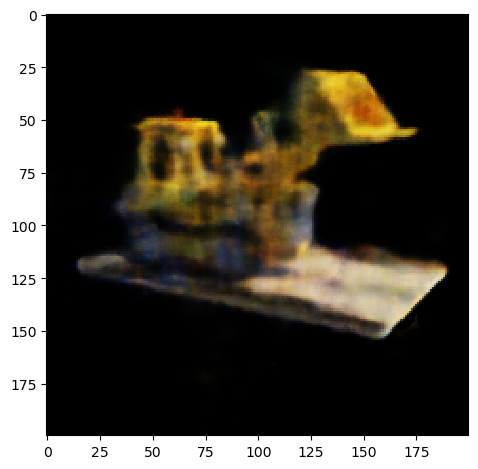

In [26]:

skio.imshow(results)
# skio.imsave("r_5000.jpg",results)

In [22]:
for index in range(len(c2ws_test)):
    print("saving: ", index)
    model.eval()
    eval_height = 200
    eval_width = 200
    c2w_eval = c2ws_val[index]
    # c2w_eval = c2ws_test[index]
    results = np.zeros((eval_height, eval_width,3))
    for i in range(eval_height):
        uv = []
        for j in range(eval_width):
            uv.append([i,j])
        ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)
        rays_o = np.repeat(ray_o, eval_height, axis=0)
        rays_d = list(ray_d)
    
        rays_o = torch.tensor(rays_o).float().to(device)
        rays_d = torch.tensor(rays_d).float().to(device)
        points = sample_along_rays(rays_o, rays_d, perturb=False)
        points = points.to(device)
        # rays_d = torch.tensor(rays_d).to(device)
        rays_d = torch.unsqueeze(rays_d,1)
        rays_d = rays_d.repeat(1,n_samples,1)
        rays_d = rays_d.view(-1,3)
        
        rgbs, sigmas = model(points, rays_d)
        rgbs = rgbs.to(device)
        sigmas = sigmas.to(device)
        # sigams = model.foward_dentisy()
        sigmas = sigmas.view(-1, n_samples, 1)
        rgbs = rgbs.view(-1, n_samples, 3)
        
        rendered_colors = volrend(sigmas, rgbs, step_size).detach().cpu().numpy()
    
        # print(rendered_colors.shape)
        results[i,:,:] = rendered_colors
    save_file_path = 'test_results/%s.png'%index  # Change the file extension as needed (e.g., .jpg, .png, .bmp, etc.)

    # Save the NumPy array as an image using skimage
    skio.imsave(save_file_path, results)

saving:  0


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  1


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  2


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  3


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  4


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  5


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  6


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  7


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  8


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  9


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  10


IndexError: index 10 is out of bounds for axis 0 with size 10